In [1]:
## Bring in needed mods
import numpy as np, pandas as pd, glob, os, scipy.stats as ss, seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
## These may need to be edited based on your paths
date = 'Jan162019'
figpath = '../FIGURES/'
filepath = '../FILES/'

In [12]:
## Bring in phenotype and genotype data
data_path = '%sTecan_qtlruns_%s_curated_baselined_median51.csv'%(filepath,date)
geno_path = '%s/CDx-ill-SNP-INDEL-df-104-blocked.csv'%(filepath)

In [13]:
## Set savepath for QTL data
#filesave = data_path.split('.csv')[0]+'_QTL_x_time.csv'

In [14]:
## Bring in genomic feature file and analysis of XL280 and 431 genes
#gff = pd.read_csv('%sxl280genome.gff3.csv.gz'%(filepath),index_col=0)
#genes = pd.read_csv('%sXL280_431_gene_analysis.csv.gz'%(filepath))

In [15]:
## Bring in more mods
from matplotlib.gridspec import GridSpec
plt.style.use(['tableau-colorblind10'])

In [16]:
## Bring in seaborn
import seaborn as sns
sns.set(font_scale=1)
sns.set(style="ticks", context="talk")

In [17]:
## Define ftns for temproal QTL mapping
def allelic_time(site, pheno,coeff = False):
    coding = np.array(site, np.float)
    pheno = np.array(pheno.loc[site.index], np.float)
    assert len(pheno) == len(coding)
    meany = pheno.mean(axis=0)
    meandummy = coding.mean(axis=0)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    # regression coefficient and intercept
    b = np.dot(ctry.T, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = np.outer(ctrdummy,b)
    
    len_yhat = np.sqrt(np.dot(yhat.T,yhat))
    len_y = np.sqrt(np.dot(ctry.T,ctry))
    df_yhat = 1
    
    error = ctry - yhat
    len_error = np.sqrt(np.dot(error.T,error))
    df_error = len(pheno) - 2
    
    F = np.diag((len_yhat**2/df_yhat) / (len_error**2/df_error))
    return F

def association_time(site, pheno):
    F = allelic_time(site, pheno)
    return -np.log10(ss.f.sf(F, 1, len(pheno)-2))

def allelic_ANOVA(site, pheno):
    """This regression is equivalent to one-way ANOVA with 2 groups. Return F-statistic.

    Assumes site is coded as -1, 1
    """
    pheno = pheno.dropna();assert len(pheno) > 0;
    coding = np.array(site[pheno.dropna().index.tolist()],np.float)
    pheno = np.array(pheno,np.float)

    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    #R = len_yhat/len_y
    
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F

def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

In [18]:
## Gather variables from phenotype data
df = pd.read_csv(data_path,index_col=0)
dfcol = df.columns.tolist()
time_ix = dfcol.index('6300s')
times_ixs = dfcol[time_ix:]
df.index = df.strain
timex = [np.round(int(a[:-1])/(60**2),3) for a in times_ixs]
dx = np.max(np.diff(timex))

In [19]:
## Gather geneotype variables like strains used. There should be 104 strains
geno_df = pd.read_csv(geno_path)
strain_ix = geno_df.columns.tolist().index('Block') + 1
geno_strains = np.array(geno_df.columns.tolist()[strain_ix:])
len(geno_strains)

104

In [20]:
## Gather unique blocks to test
loci_ix = geno_df['Block'].drop_duplicates().index
len(loci_ix)

3108

In [21]:
geno_x = geno_df[geno_strains].T[loci_ix].T

In [22]:
genoxdf = pd.concat([geno_df[geno_df.columns[:strain_ix]].T[loci_ix].T,geno_x],axis=1)

In [23]:
from matplotlib import rc
amphB_text = 'Amphotericin B'
parentals = ['SS-A837','XL280a','XL280alpha']
xl280al = 'XL280'+r'$\alpha$'#+'SS'
xl280a = 'XL280' +r'$\bf{a}$'
_431 = '431'+r'$\mathrm{\alpha}$'
segs = [s for s in geno_strains 
        if s not in parentals]

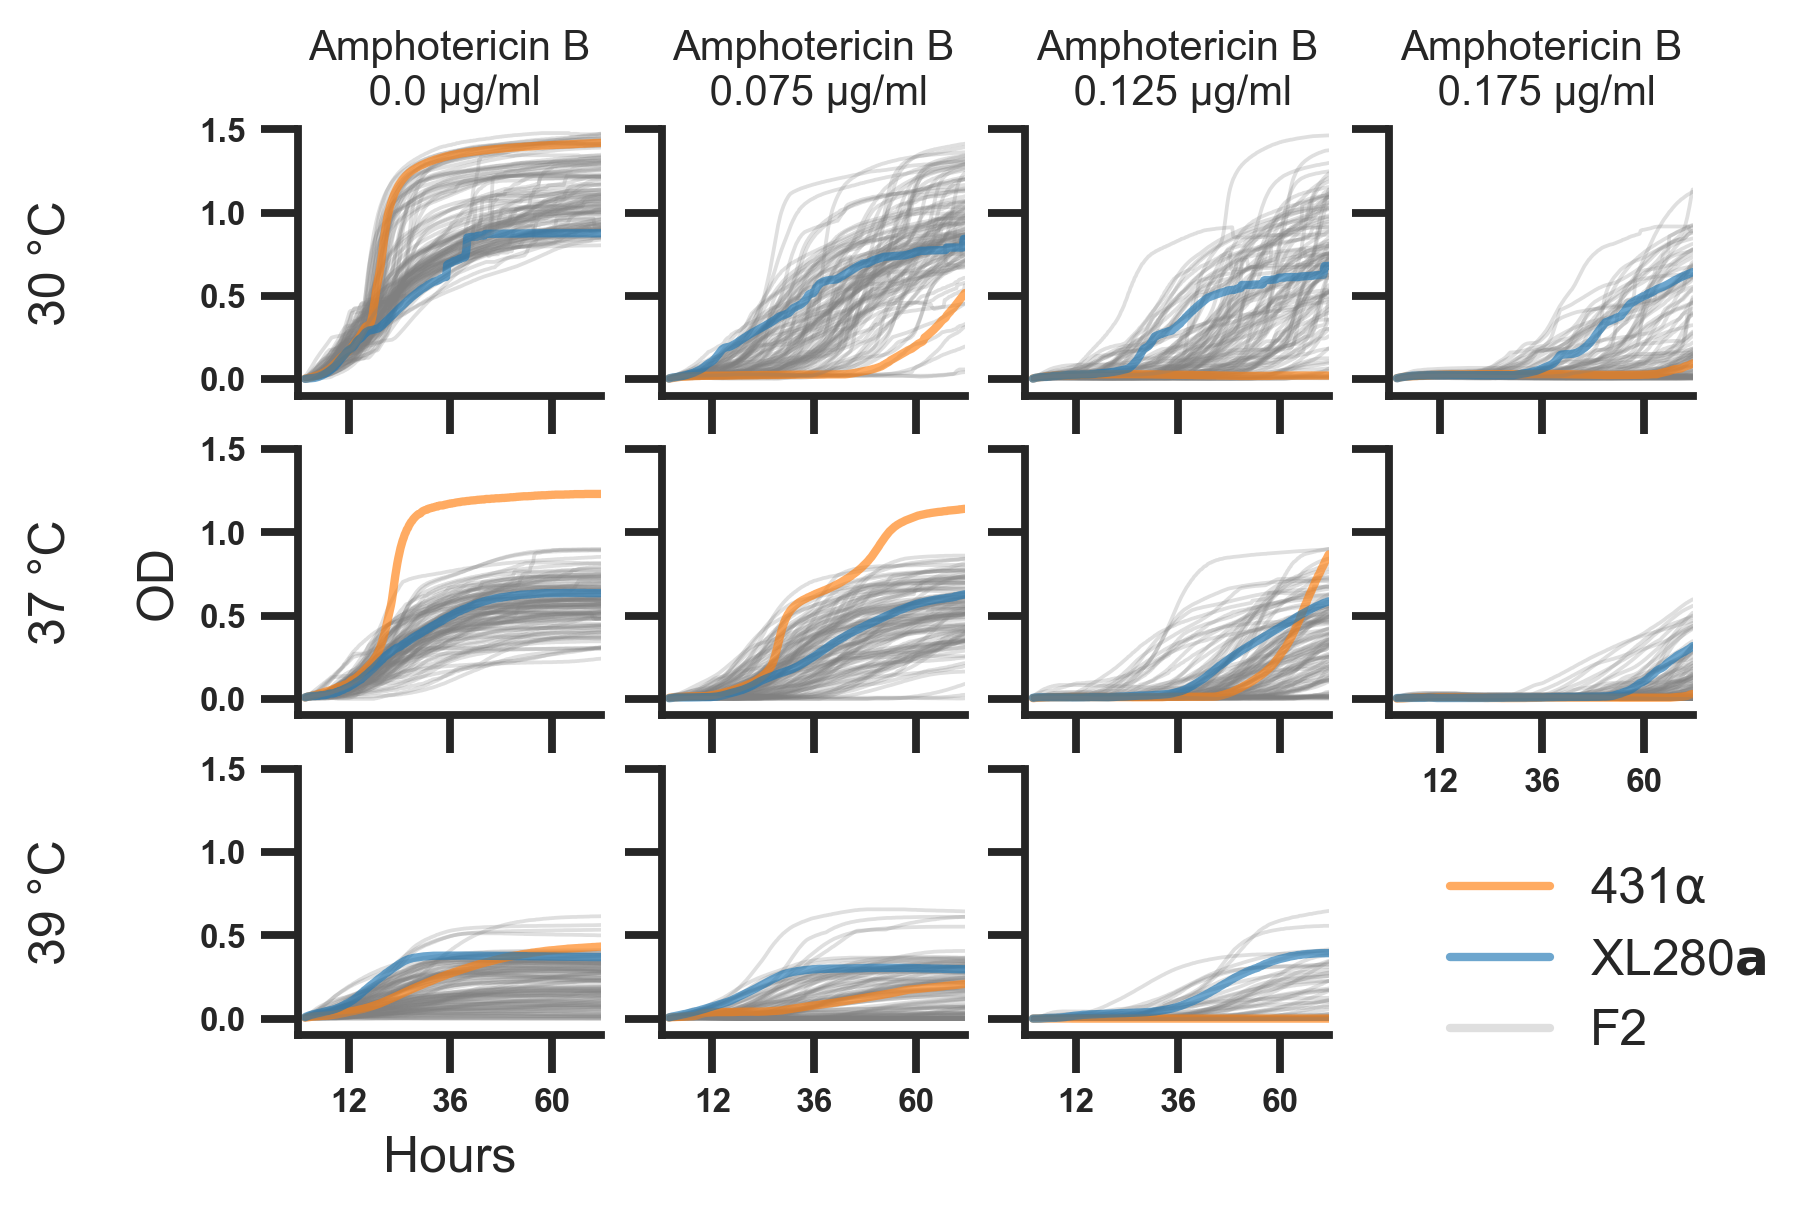

In [24]:
temps = [30,37,39]
drugs = [0.0,0.075,0.125,0.175]
mydpi=300
fs = 12
fig, ax = plt.subplots(len(temps),len(drugs),
                       sharey=True,sharex=False,
                       figsize=(6,4),dpi=mydpi)
for i, t in enumerate(temps):
    for j, d in enumerate(drugs):
        if (i == 0):# and (j > 0):
            plt.sca(ax[i,j])
            plt.title('%s\n %s \u03BCg/ml'%(amphB_text,d),fontsize=10)
        tempdf = df[(df.temp==t) & (df.amphB==d)]
        if tempdf.shape[0] == 0:
            pass
        else:
            tempdf.index = tempdf.strain
            med_cum_od = tempdf[times_ixs].groupby(tempdf.index).agg('median').T
            plt.sca(ax[i,j])
            plt.ylim(-0.1,1.5)
            if i == 2: 
                plt.xticks(np.arange(12,72,1)[::24],
                       label=np.arange(12,72,1)[::12],
                       fontsize=8,fontweight='bold')
            elif (i == 1) and (j == 3):
                plt.xticks(np.arange(12,72,1)[::24],
                       label=np.arange(12,72,1)[::12],
                       fontsize=8,fontweight='bold')
            else:
                plt.xticks(np.arange(12,72,1)[::24])
            plt.yticks(np.arange(0,2,.5),fontsize=8,fontweight='bold')
            plt.plot(timex,med_cum_od[segs[:-1]].values,
                     alpha=0.25,color='grey',linewidth=.9);
            plt.plot(timex,med_cum_od['SS-A837'].values,
                     alpha=0.65,color='tab:orange',linewidth=2,
                     label=_431 if (i == 2) and (j ==2) else None);
            plt.plot(timex,med_cum_od['XL280a'].values,
                     linewidth=2,
                     alpha=0.65,color='tab:blue',linestyle='-',
                     label= xl280a if (i == 2) and (j ==2) else None);

            plt.plot(timex,med_cum_od[segs[-1]].values,
                     alpha=0.25,color='grey',linewidth=.9,
                    label='F2' if (i == 2) and (j ==2) else None);
            [ax[i,j].spines[a].set_visible(False) for a in ['top','right']]
            plt.xlim(0,np.max(timex))

plt.sca(ax[-1,0]);
plt.xlabel('Hours',fontsize=fs)
plt.sca(ax[-1,-2])
leg = plt.legend(frameon=False,bbox_to_anchor=[1.25,.8],fontsize=fs,ncol=1);

for line in leg.get_lines():
    line.set_linewidth(2.0)

plt.sca(ax[-1,-1]);plt.axis('off')
for i,t in enumerate(temps):
    if i == 1:
        ytext = u'%s °C\n\nOD'%(t)
    else:
        ytext = u'%s °C\n\n'%(t)
    plt.sca(ax[i,0])
    plt.ylabel(ytext,fontsize=fs)
plt.subplots_adjust(wspace=0.2,hspace=0.2)
for i in np.arange(7):
    plt.sca(ax.ravel()[i]);plt.xticks([12,36,60],labels=[])
#axm = fig.add_axes([-0.04,0.2,0.1,.8])
#fig.savefig('%sCdx_median_od_timexamphb_for_paper.png'%(figpath),
#            dpi=300,bbox_inches='tight');

In [25]:
t = 30
d = 0.0
tempdf = df[(df.temp==t) & (df.amphB==d)]
tempdf.index = tempdf.strain
med_cum_od = tempdf[times_ixs].groupby(tempdf.index).agg('median').T

strain   SS-A837  SS-B307  SS-B308  SS-B310  SS-B311  SS-B312  SS-B313  \
6300s     0.0030   0.0025   0.0053   0.0019   0.0091  0.00058   0.0114   
7201s     0.0035   0.0025   0.0069   0.0041   0.0116  0.00158   0.0154   
8100s     0.0045   0.0027   0.0094   0.0056   0.0136  0.00208   0.0192   
9000s     0.0065   0.0032   0.0124   0.0081   0.0156  0.00208   0.0246   
9901s     0.0075   0.0047   0.0154   0.0101   0.0177  0.00308   0.0296   
10800s    0.0095   0.0062   0.0184   0.0131   0.0207  0.00358   0.0341   
11700s    0.0105   0.0077   0.0213   0.0156   0.0242  0.00408   0.0381   
12601s    0.0125   0.0097   0.0248   0.0191   0.0277  0.00508   0.0432   
13500s    0.0150   0.0112   0.0283   0.0221   0.0312  0.00608   0.0482   
14400s    0.0173   0.0132   0.0318   0.0266   0.0357  0.00658   0.0537   
15301s    0.0193   0.0147   0.0358   0.0291   0.0397  0.00758   0.0602   
16200s    0.0213   0.0172   0.0393   0.0356   0.0442  0.00908   0.0657   
17100s    0.0233   0.0192   0.0428   0.0391   0.0492  0.00958   0.0717   
18001s    0.0258   0.0217   0.0468   0.0441   0.0547  0.01108   0.0777   
18900s    0.0283   0.0247   0.0508   0.0486   0.0597  0.01208   0.0836   
19800s    0.0313   0.0282   0.0548   0.0541   0.0647  0.01408   0.0891   
20701s    0.0348   0.0317   0.0583   0.0601   0.0707  0.01608   0.0946   
21600s    0.0378   0.0352   0.0623   0.0656   0.0772  0.01808   0.0991   
22500s    0.0408   0.0392   0.0668   0.0716   0.0832  0.02043   0.1041   
23401s    0.0448   0.0432   0.0708   0.0766   0.0897  0.02293   0.1091   
24300s    0.0483   0.0477   0.0753   0.0831   0.0967  0.02593   0.1141   
25200s    0.0528   0.0522   0.0798   0.0891   0.1037  0.02893   0.1186   
26101s    0.0573   0.0572   0.0848   0.0961   0.1107  0.03193   0.1221   
27000s    0.0618   0.0622   0.0898   0.1026   0.1177  0.03543   0.1246   
27900s    0.0673   0.0687   0.0958   0.1111   0.1252  0.03943   0.1271   
28801s    0.0728   0.0752   0.1013   0.1191   0.1322  0.04393   0.1281   
29700s    0.0788   0.0817   0.1068   0.1271   0.1392  0.04843   0.1296   
30600s    0.0853   0.0887   0.1133   0.1351   0.1467  0.05293   0.1306   
31501s    0.0918   0.0957   0.1198   0.1436   0.1537  0.05743   0.1326   
32400s    0.0983   0.1032   0.1258   0.1521   0.1602  0.06243   0.1336   
...          ...      ...      ...      ...      ...      ...      ...   
231301s   1.4100   0.9707   1.0065   0.9004   1.0460  0.84565   1.2197   
232200s   1.4100   0.9712   1.0095   0.9009   1.0460  0.84665   1.2197   
233100s   1.4100   0.9712   1.0125   0.9024   1.0465  0.84915   1.2197   
234001s   1.4105   0.9712   1.0155   0.9029   1.0470  0.85015   1.2197   
234900s   1.4110   0.9712   1.0185   0.9044   1.0470  0.85215   1.2197   
235800s   1.4115   0.9712   1.0215   0.9054   1.0475  0.85365   1.2192   
236701s   1.4115   0.9712   1.0250   0.9069   1.0475  0.85565   1.2187   
237600s   1.4120   0.9712   1.0275   0.9079   1.0475  0.85715   1.2187   
238500s   1.4125   0.9712   1.0310   0.9084   1.0475  0.85915   1.2187   
239401s   1.4130   0.9712   1.0345   0.9094   1.0475  0.86015   1.2187   
240300s   1.4130   0.9712   1.0380   0.9104   1.0475  0.86265   1.2187   
241200s   1.4135   0.9712   1.0415   0.9114   1.0480  0.86365   1.2187   
242101s   1.4135   0.9712   1.0450   0.9119   1.0480  0.86515   1.2187   
243000s   1.4135   0.9712   1.0490   0.9129   1.0480  0.86665   1.2187   
243900s   1.4140   0.9712   1.0530   0.9139   1.0485  0.86815   1.2187   
244801s   1.4145   0.9712   1.0570   0.9149   1.0485  0.87015   1.2187   
245700s   1.4145   0.9717   1.0605   0.9154   1.0485  0.87165   1.2182   
246600s   1.4150   0.9717   1.0640   0.9164   1.0495  0.87365   1.2182   
247501s   1.4150   0.9717   1.0675   0.9174   1.0495  0.87480   1.2182   
248400s   1.4160   0.9717   1.0720   0.9184   1.0495  0.87580   1.2182   
249300s   1.4160   0.9712   1.0760   0.9194   1.0495  0.87680   1.2177   
250201s   1.4160   0.9717   1.0805   0.9204   1.0500  0.87780   1.2177   
2511

In [27]:
ym = med_cum_od.mean(axis=1)

In [35]:
med_cum_od_m = med_cum_od.T - ym.values

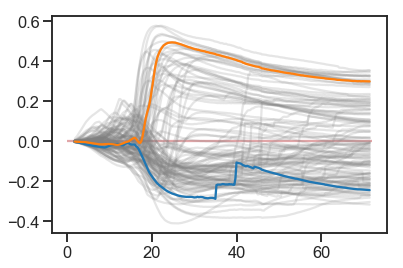

In [46]:
plt.hlines(0,0,72,color='r',alpha=0.5);
plt.plot(timex,med_cum_od_m.T.values,alpha=0.2,color='grey');
plt.plot(timex,med_cum_od_m.T['XL280a'].values,color='tab:blue');
plt.plot(timex,med_cum_od_m.T['SS-A837'].values,color='tab:orange');

In [19]:
txd = df[['temp','amphB']].drop_duplicates().values

In [20]:
from mpl_toolkits import mplot3d

In [21]:
labels = [xl280a,_431]

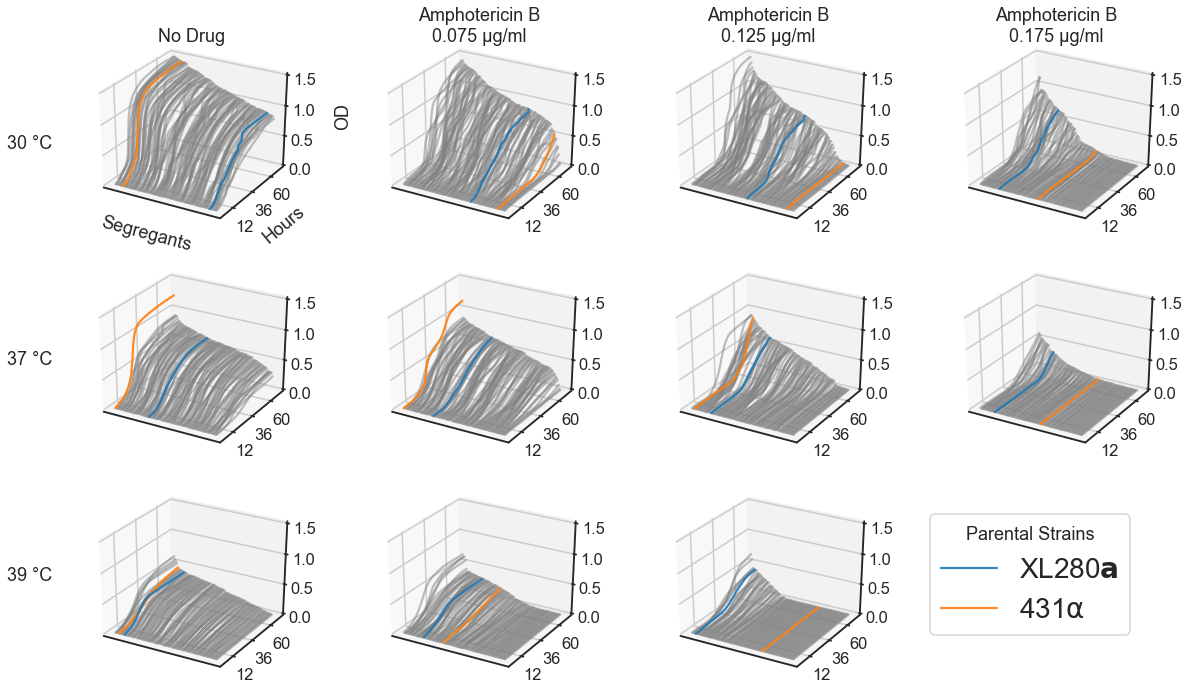

In [22]:
fig = plt.figure(figsize=(20,12))
for k,td in enumerate(txd):
    t = td[0]
    d = td[1]
    tempdf = df[(df.temp==t) & (df.amphB==d)]
    tempdf.index= tempdf.strain
    od_segs = tempdf.groupby(tempdf.index).agg('median')[times_ixs]
    ordered = [s for s in od_segs.max(axis=1).sort_values().index if s in geno_strains]
    ax = fig.add_subplot(3, 4, k+1, projection='3d')
    parentx = []
    for j,s in enumerate(ordered[::-1]):
        if s in ['XL280a','SS-A837']:
            parentx.append((j,s))
        else:
            ax.plot3D([j for i in timex],timex,od_segs.T[s].T.values,
              color='grey',alpha=0.5)#label='F2' if (j == 103) and (k == 10) else None)
    for j,a in enumerate(parentx):
        if a[1] == 'SS-A837':
            mc = 'tab:orange'
        else:
            mc = 'tab:blue'
        ax.plot3D([a[0] for i in timex],timex,od_segs.T[a[1]].T.values,
              color=mc,alpha=0.9,label=labels[j] if k == 10 else None)
    ax.set_xticks([])
    if k == 0:
        ax.set_xlabel('Segregants')
        ax.set_ylabel('\nHours')
        ax.set_zlabel('\n\nOD',rotation=90);
    ax.dist = 10.5
    ax.set_zlim(0,1.5)
    if t == 30:
        if d == 0.0:
            plt.title('No Drug')
        else:
            plt.title('Amphotericin B\n%s \u03BCg/ml'%(d))
    plt.yticks([12,36,60])
plt.subplots_adjust(hspace=.1,wspace=0.15)
plt.sca(ax)
plt.legend(bbox_to_anchor=(2,.9),title='Parental Strains',prop={"size":28});
[fig.text(.1,0.75-(0.25*i),u'%s °C'%(t),
             ha='center',va='center') 
 for i,t in enumerate(temps)];

plt.savefig('%sCdx_3D_growth_Matrix.png'%(figpath),
            dpi=300,figsize=(10,4),bbox_inches='tight');

In [24]:
for i, td in enumerate(txd):
    t = td[0]
    d = td[1]
    tempdf = df[(df.temp==t) & (df.amphB==d)]
    tempdf.index= tempdf.strain
    cum_med_od = (tempdf[times_ixs].groupby(tempdf.index)[times_ixs
                ].cumsum(axis=1)*dx).groupby(tempdf.index).agg(np.median)
    AUCgx = (cum_med_od.T[segs].T[times_ixs[-1]] > cum_med_od.T['XL280a'].T[times_ixs[-1]]).sum()
    print(t,d,np.round(AUCgx/len(segs),2))

30.0 0.0 0.89
30.0 0.075 0.33
30.0 0.125 0.24
30.0 0.175 0.19
37.0 0.0 0.35
37.0 0.075 0.44
37.0 0.125 0.24
37.0 0.175 0.18
39.0 0.0 0.06
39.0 0.075 0.07
39.0 0.125 0.07


In [25]:
if not os.path.exists(filesave):
    kwak_time = []
    for i, td in enumerate(txd):
        t = td[0]
        d = td[1]
        tempdf = df[(df.temp==t) & (df.amphB==d)]
        tempdf.index= tempdf.strain
        cum_med_od = (tempdf[times_ixs].groupby(tempdf.index)[times_ixs
                ].cumsum(axis=1)*dx).groupby(tempdf.index).agg(np.median)
        kwak = genoxdf[geno_strains].apply(association_time,axis=1,
                args=[cum_med_od.T[geno_strains].T[times_ixs]]);
        kwak_time.append(kwak)

In [26]:
if not os.path.exists(filesave):
    un_folddfs = []
    for i,td in enumerate(txd):
        kwak = kwak_time[i]
        tempdf = pd.DataFrame.from_dict(dict(zip(kwak.index,kwak.values))).T
        tempdf.columns = times_ixs
        tempdf['Max'] = tempdf.max(axis=1)
        tempdf['Mean'] = tempdf.mean(axis=1)
        tempdf['Temp'] = td[0]
        tempdf['AmphB'] = td[1]
        tempdf[['Chrom','Pos','Block']] = geno_df.T[tempdf.index].T[['Chrom','Pos','Block']]
        un_folddfs.append(tempdf)
    qtlxt = pd.concat(un_folddfs)

In [27]:
if not os.path.exists(filesave):
    qtlxt.to_csv(filesave)
else:
    qtlxt = pd.read_csv(filesave,index_col=0)

In [28]:
qtlxt.head()

6300s     7201s     8100s     9000s     9901s    10800s    11700s  \
0    1.616844  1.442372  1.323125  1.214601  1.074869  0.981114  0.897696   
232  1.701407  1.504731  1.402243  1.315138  1.184864  1.090923  1.009895   
249  1.564001  1.398014  1.307982  1.217620  1.083910  1.005929  0.950789   
252  1.745203  1.588588  1.486405  1.401833  1.260169  1.178759  1.124104   
254  1.349813  1.220050  1.120642  1.024163  0.892663  0.820984  0.774094   

       12601s    13500s    14400s  ...   255601s   256500s   257400s  \
0    0.832349  0.808413  0.762842  ...  1.472259  1.472943  1.473625   
232  0.942229  0.919812  0.875266  ...  0.943044  0.943590  0.944140   
249  0.902686  0.901738  0.876100  ...  0.518388  0.518724  0.519062   
252  1.074089  1.075751  1.049330  ...  0.321287  0.321559  0.321834   
254  0.732197  0.735129  0.725028  ...  0.268248  0.268508  0.268773   

          Max      Mean  Temp  AmphB  Chrom    Pos  Block  
0    1.616844  1.113267  30.0    0.0  Chr01   5016      0  
232  1.701407  0.821742  30.0    0.0  Chr01  35512      1  
249  1.564001  0.526887  30.0    0.0  Chr01  36364      2  
252  1.745203  0.485633  30.0    0.0  Chr01  36573      3  
254  1.349813  0.410301  30.0    0.0  Chr01  36769      4  

[5 rows x 287 columns]

In [29]:
qtlxt.shape

(34188, 287)

In [30]:
chrlist = genoxdf.Chrom.unique()
## Gather the length of each chromosome
clens = [genoxdf[(genoxdf.Chrom==chrom)]['Pos'].max() 
         for chrom in chrlist]
## Set mid points
chrom_midpts = 0.5 * np.sum(np.array([a 
                    for a in zip([0]+list(np.cumsum(clens)),
                            np.cumsum(clens))]),axis=1)
cumpos = [0] + list(np.cumsum(clens))[:-1]

In [31]:
qtlxt['Cumpos'] = -1 
for i, c in enumerate(chrlist):
    qtlxt.loc[(qtlxt.Chrom==c),'Cumpos'] = qtlxt[(qtlxt.Chrom==c)]['Pos'] + cumpos[i]
assert np.sum(qtlxt.Cumpos == -1) == 0

In [32]:
Fmax = np.ceil(qtlxt.Max.max())
Fmax

8.0

In [33]:
Fmin = 0

In [34]:
thresholds = pd.read_csv('%sCdx-aucxt-thresholds-Sep2019.csv'%(filepath),index_col=0)

In [35]:
thresholds.shape

(33, 5)

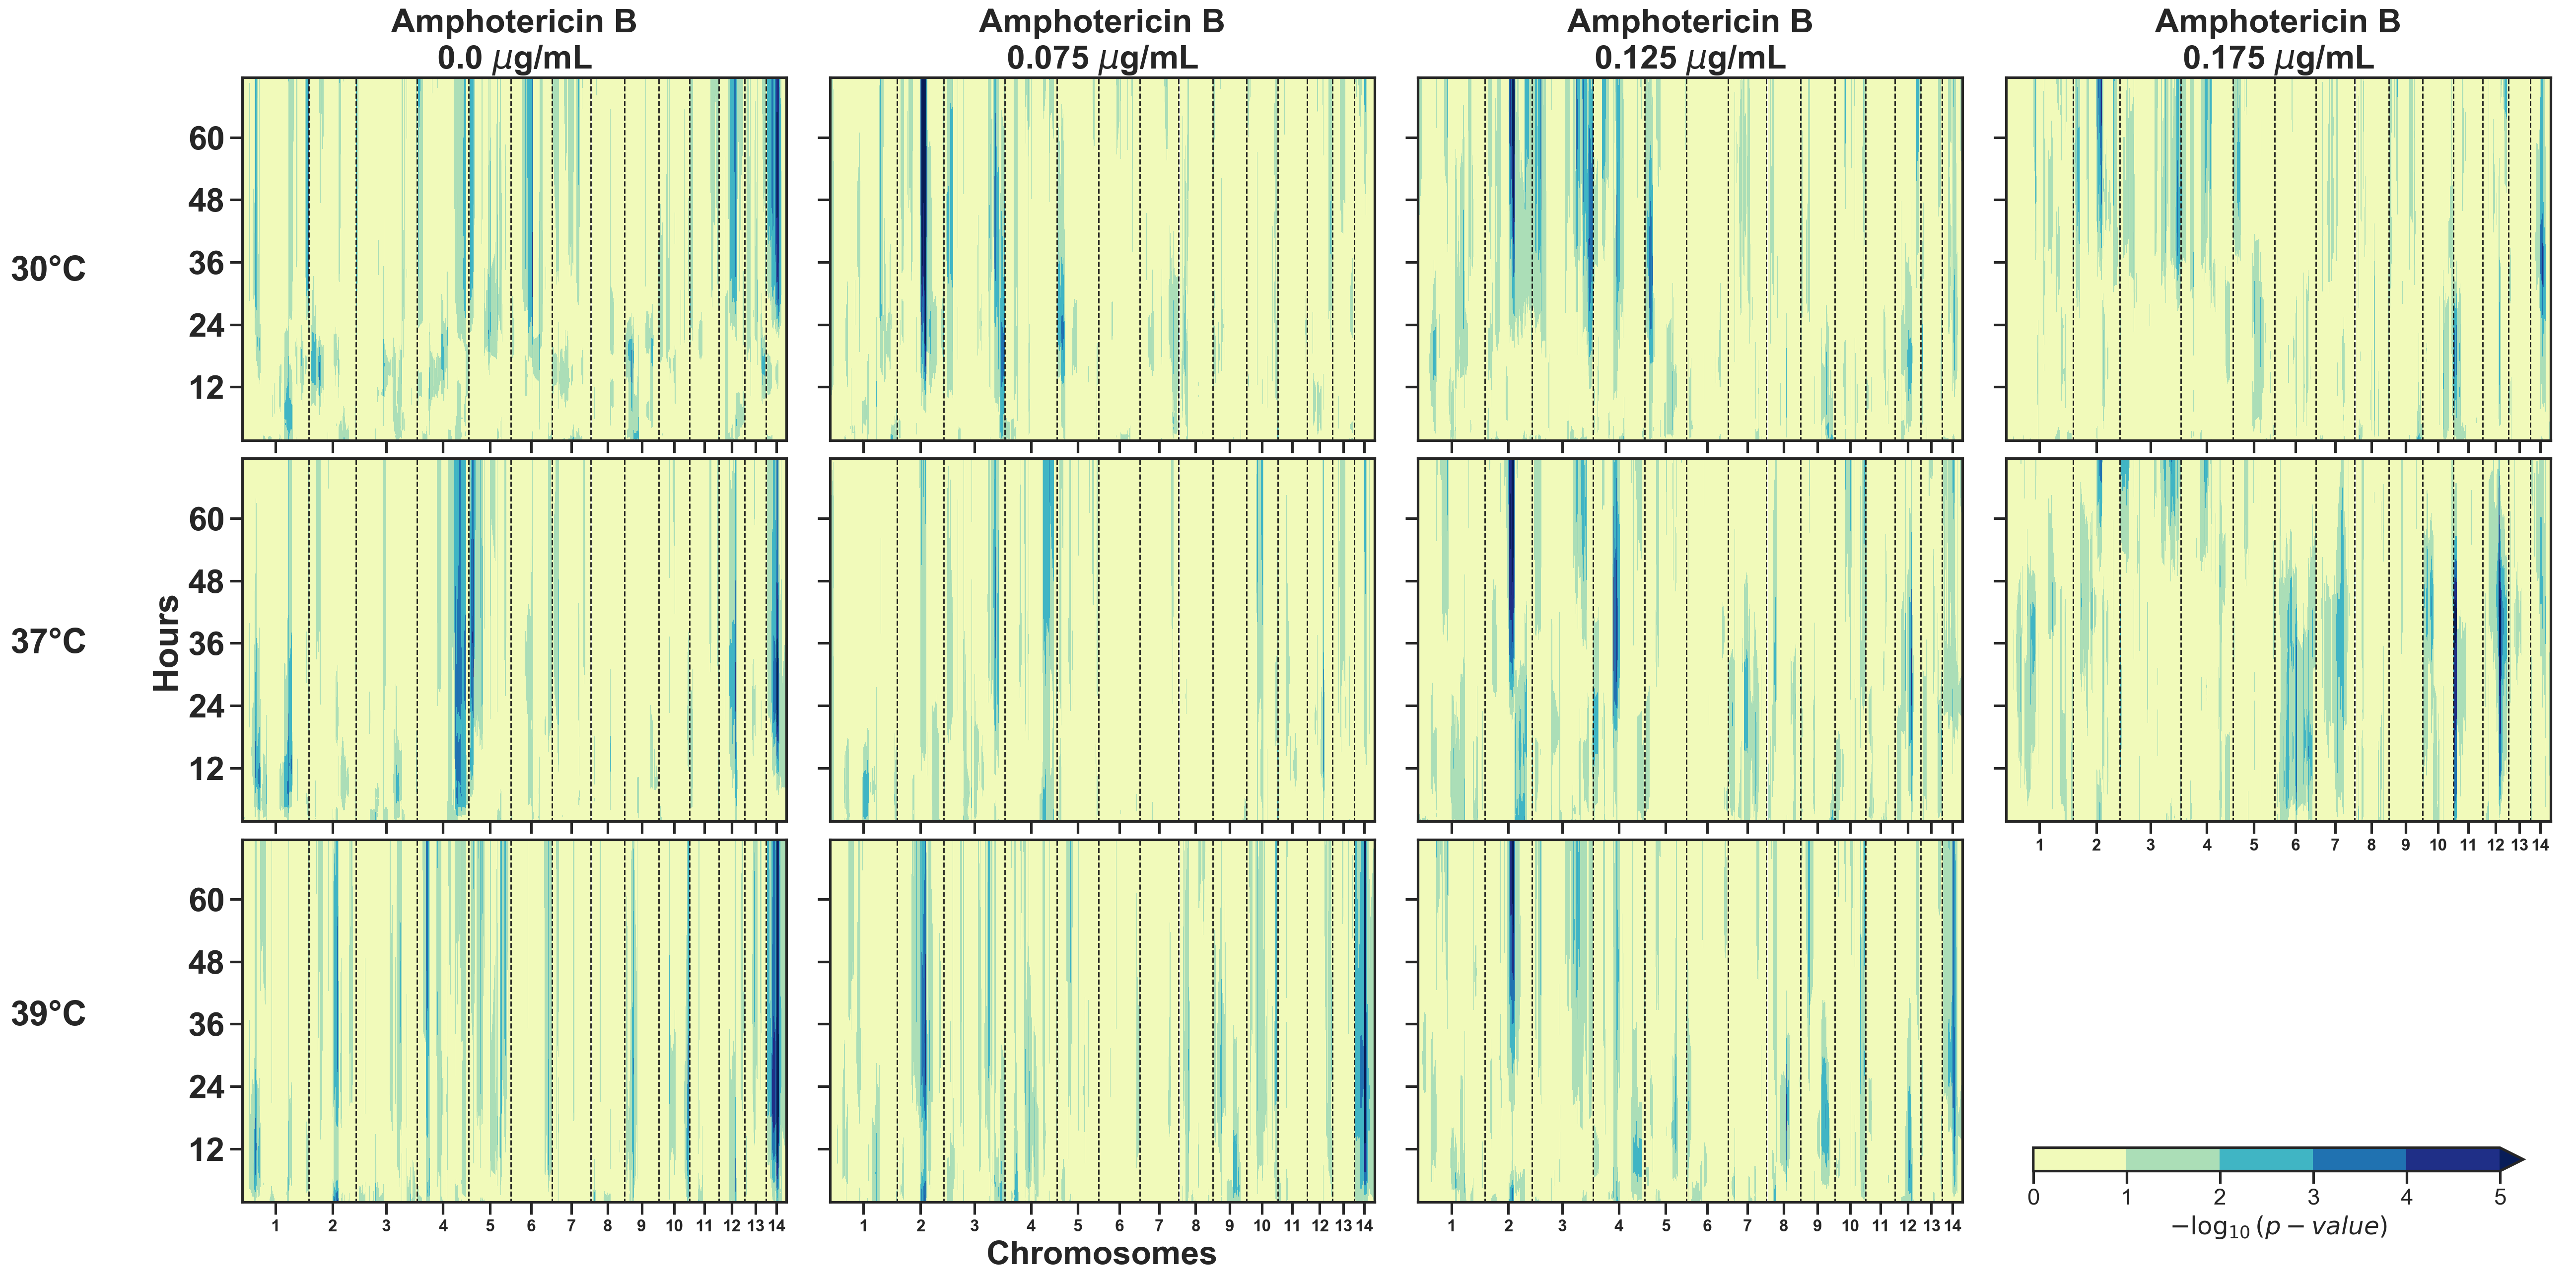

In [36]:
mydpi= 200
fig, ax = plt.subplots(3,4,sharey=True,sharex=False,
                       figsize=(30,15),dpi=mydpi)
for i, td in enumerate(txd):
    for c,chrom in enumerate(chrlist):
        temp = qtlxt[(qtlxt.Temp==td[0]) & (qtlxt.AmphB==td[1]) & 
            (qtlxt.Chrom==chrom)][times_ixs+['Pos']]
        chpos = temp.Pos.values + cumpos[c]
        cs = ax.ravel()[i].contourf(chpos,timex,temp[times_ixs].T.values,cmap="YlGnBu",
                                    levels=np.arange(thresholds['0.05'].max().round(2)),extend='max');
    if i in np.arange(4):
        plt.sca(ax.ravel()[i])
        plt.title('Amphotericin B\n'+str(td[1])+' ${\mu}$'+ 'g/mL',fontsize=24,fontweight='bold')      
    
    ax.ravel()[i].vlines(np.array(clens) + np.array(cumpos),
                         0,np.max(timex),
           color='k',linewidth=1,linestyle='--');
    ax.ravel()[i].set_xticks(chrom_midpts);
    if i >= 7:
        ax.ravel()[i].set_xticklabels(np.arange(1,15),
                    fontsize=12,fontweight='bold');
    else:
        ax.ravel()[i].set_xticklabels([' '])
    ax.ravel()[i].set_yticks([12,24,36,48,60]);
    ax.ravel()[i].set_yticklabels([12,24,36,48,60],
                    fontsize=24,fontweight='bold');
plt.ylim(np.min(timex),np.max(timex))
fig.colorbar(cs, ax=ax[-1,-1], shrink=.9,
             label='$-\log_{10}\,(p-value)$',
             #orientation='vertical')
             orientation='horizontal');
ax[-1,-1].axis('off')
plt.subplots_adjust(wspace=0.08,hspace=0.05);
plt.sca(ax[-1,1])
plt.xlabel('Chromosomes',fontweight='bold',
         size=24);

plt.sca(ax[1,0])
plt.ylabel('Hours',fontweight='bold',size=25);
tl = 0.06

[fig.text(tl,0.75-(0.25*i),u'%s°C'%t,ha='center',va='center',
          fontsize=25,fontweight='bold') 
 for i,t in enumerate(temps)] 
fig.savefig('%scdx_time_QTL_AUCdxt_contour_matrix.png'%(figpath),
            dpi=mydpi,bbox_inches='tight');

In [37]:
import matplotlib.gridspec as gridspec
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('tableau-colorblind10')

In [38]:
t = 37
d = 0.125
tempdf = df[(df.temp==t) & (df.amphB==d)]
tempdf.index= tempdf.strain
od_segs = tempdf.groupby(tempdf.index).agg('median')[times_ixs]

In [39]:
od_segs.shape

(119, 280)

In [40]:
pcolors = ['tab:orange','tab:brown','tab:red']

/Users/croth/anaconda3/lib/python3.7/site-packages/matplotlib/colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


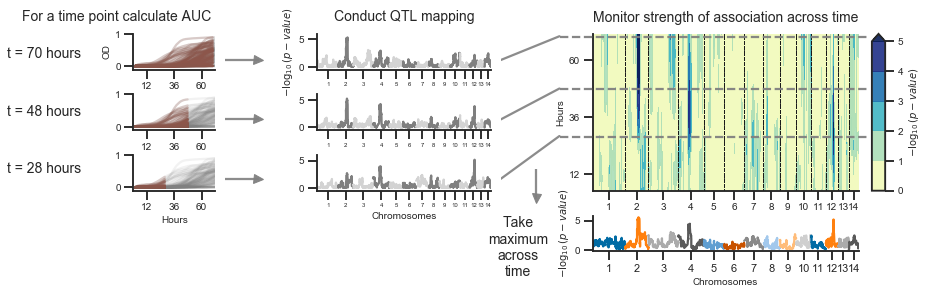

In [43]:
fig = plt.figure(figsize=(13,4))
gs = fig.add_gridspec(4,8,hspace=.7,wspace=.12)
timesoi = [28,48,70][::-1]

for i, j in enumerate(timesoi):
    ax = fig.add_subplot(gs[i,0])
    plt.title('For a time point calculate AUC' if i == 0 else None,
              fontsize=14,x=-.2,y=1.2)
    plt.plot(timex, od_segs[times_ixs].T[geno_strains],
             alpha=0.1,color='grey')
    plt.plot(timex[:timex.index(j)],
         od_segs[times_ixs[:timex.index(j)]].T[geno_strains],
             alpha=0.25,color='tab:brown')#pcolors[i])
    plt.ylim(-0.1,1);plt.xlim(0,72);
    plt.xticks([12,36,60],fontsize=10)
    plt.xlabel('Hours' if i == 2 else None,fontsize=10)
    plt.ylabel('OD' if i == 0 else None,fontsize=10)
    [ax.spines[k].set_visible(False)  
             for k in ['top','right']];
    plt.yticks([0,1],fontsize=10)
    
for i, j in enumerate(timesoi):
    ax = fig.add_subplot(gs[i,2:4])
    plt.title('Conduct QTL mapping' if i == 0 else None,
              fontsize=14,x=.5,y=1.2)
    for c,chrom in enumerate(chrlist):
        temp = qtlxt[(qtlxt.Temp== t) & 
                 (qtlxt.AmphB== d) & 
                 (qtlxt.Chrom==chrom)
                ][[times_ixs[timex.index(j)]]+['Pos']]
        chpos = temp.Pos.values + cumpos[c]
        plt.plot(chpos,temp[times_ixs[timex.index(j)]],
                 color='lightgrey' if c%2==0 else 'tab:grey')
    plt.xticks(chrom_midpts,labels=np.arange(1,15),fontsize=6)
    plt.ylim(-0.5,6)

    plt.ylabel('$-\log_{10}\,(p-value)$' if i ==0 else None,fontsize=10)
    plt.xlabel('Chromosomes' if i == 2 else None, fontsize=10)
    [ax.spines[k].set_visible(False)  
             for k in ['top','right']];
    plt.xlim(0,temp.Pos.max()+cumpos[c])
    plt.yticks([0,5],fontsize=10)
    
## ----------------------- QTL heat map plot ---------------------- ##
ax = fig.add_subplot(gs[:-1,-3:])
plt.title('Monitor strength of association across time',
          x=.5,y=1.04,fontsize=14)
for c,chrom in enumerate(chrlist):
    temp = qtlxt[(qtlxt.Temp== t) & (qtlxt.AmphB== d) & 
        (qtlxt.Chrom==chrom)][times_ixs+['Pos']]
    chpos = temp.Pos.values + cumpos[c]
    cs = ax.contourf(chpos,timex,temp[times_ixs].T.values,cmap="YlGnBu",
                        levels=np.arange(thresholds['0.05'].max().round(2)),
                     extend='max',alpha=0.9);

    plt.vlines(np.array(clens) + np.array(cumpos),
                1.75,np.max(timex),
               color='k',linewidth=1,linestyle='--');
    plt.xticks(chrom_midpts, labels = np.arange(1,15), fontsize=10)
    ax.set_yticks([12,36,60]);
    [ax.spines[k].set_visible(False)  
             for k in ['top','right']];
#plt.ylim(71,5)
plt.ylim(5,71)
plt.yticks([12,36,60],fontsize=10)
plt.xlim(0,temp.Pos.max() + np.max(cumpos))
plt.ylabel('Hours',fontsize=10)

## ----------------- Add color bar ----------------------- ##
axins = inset_axes(ax,
           width="5%", # width = 10% of parent_bbox width
           height="100%", # height : 50%
           loc=6,
           bbox_to_anchor=(1.05, 0., 1, 1),
           bbox_transform=ax.transAxes,
           borderpad=0,)

cbar = plt.colorbar(cs, cax=axins)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=10)
plt.yticks(np.arange(6),fontsize=10)

## ----------- Lines connecting the qtl maps to heat map -------- ##
line_pts = [10,35,60]
ax = fig.add_subplot(gs[:-1,4])
plt.ylim(5,71)
plt.xlim(0,.7)
plt.plot([0,.5],
         np.array(list(zip(line_pts,timesoi[::-1]))).T,
         color='k',alpha=.5)
plt.axis('off')

## ------------------------- Curves to QTL ---------------------- ##
ax = fig.add_subplot(gs[:-1,1])
plt.ylim(5,71)
plt.xlim(0,1.5)
plt.plot([0,.6],
         np.array(list(zip(line_pts,line_pts))).T,
         color='k',alpha=.5)
plt.plot(.6*np.ones(len(timesoi)),line_pts,'>',
         color='grey',alpha=.95)
plt.axis('off')

## ------------------------- Draw dashed lines -------------- ##
fig.add_axes([0.565,0.333,0.36,0.546]);
u=1.     #x-position of the center
a=2.     #radius on the x-axis
b=1.4    #radius on the y-axis
for v in timesoi:
    plt.hlines(v,0,1,linestyle='--',
               color='grey',alpha=0.95)
plt.ylim(5,71)
plt.axis('off')


ax = fig.add_subplot(gs[-1,-3:])
for c,chrom in enumerate(chrlist):
    temp = qtlxt[(qtlxt.Temp== t) & (qtlxt.AmphB== d) & 
        (qtlxt.Chrom==chrom)][['Max','Pos']]
    chpos = temp.Pos.values + cumpos[c]
    plt.plot(chpos,temp.Max)
[ax.spines[k].set_visible(False) for k in ['top','right']];
plt.xticks(chrom_midpts,labels=np.arange(1,15),fontsize=11)
plt.xlim(0,temp.Pos.max() + np.max(cumpos))
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
plt.yticks([0,5],fontsize=10)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=10)
plt.xlabel('Chromosomes',fontsize=10);
plt.text(-0.28,0.11,'Take\nmaximum\nacross\ntime',
         fontsize=14,transform=ax.transAxes,
         va='center',ha='center')

tx = 0.03
ty = [.81,.61,.41]
#fig.text(tx,.91,'For a time point',
#         fontsize=16,ha='center',va='center');
[fig.text(tx,ty[i],'t = %s hours'%(tpt),
          fontsize=14,ha='center',va='center')
 for i,tpt in enumerate(timesoi)];

#plt.plot([0.5,0.5],[0.5,1],color='k',alpha=0.5)
#plt.plot([0.5],[0.5],'v',color='grey',alpha=0.95)

fig.add_axes([0.54,0.26,0.03,0.15]);
plt.plot([0.5,0.5],[0.5,1],color='k',alpha=0.5)
plt.plot([0.5],[0.5],'v',color='grey',alpha=0.95)
plt.ylim([0.25,1])
plt.axis('off')

plt.savefig('%sCdx-temporal-eg-QTL.png'%(figpath),
            dpi=300,bbox_inches='tight');

In [44]:
sigs_ls = ('dotted','dashed')
sig_labs = ('\u03B1 = 0.01','\u03B1 = 0.05')

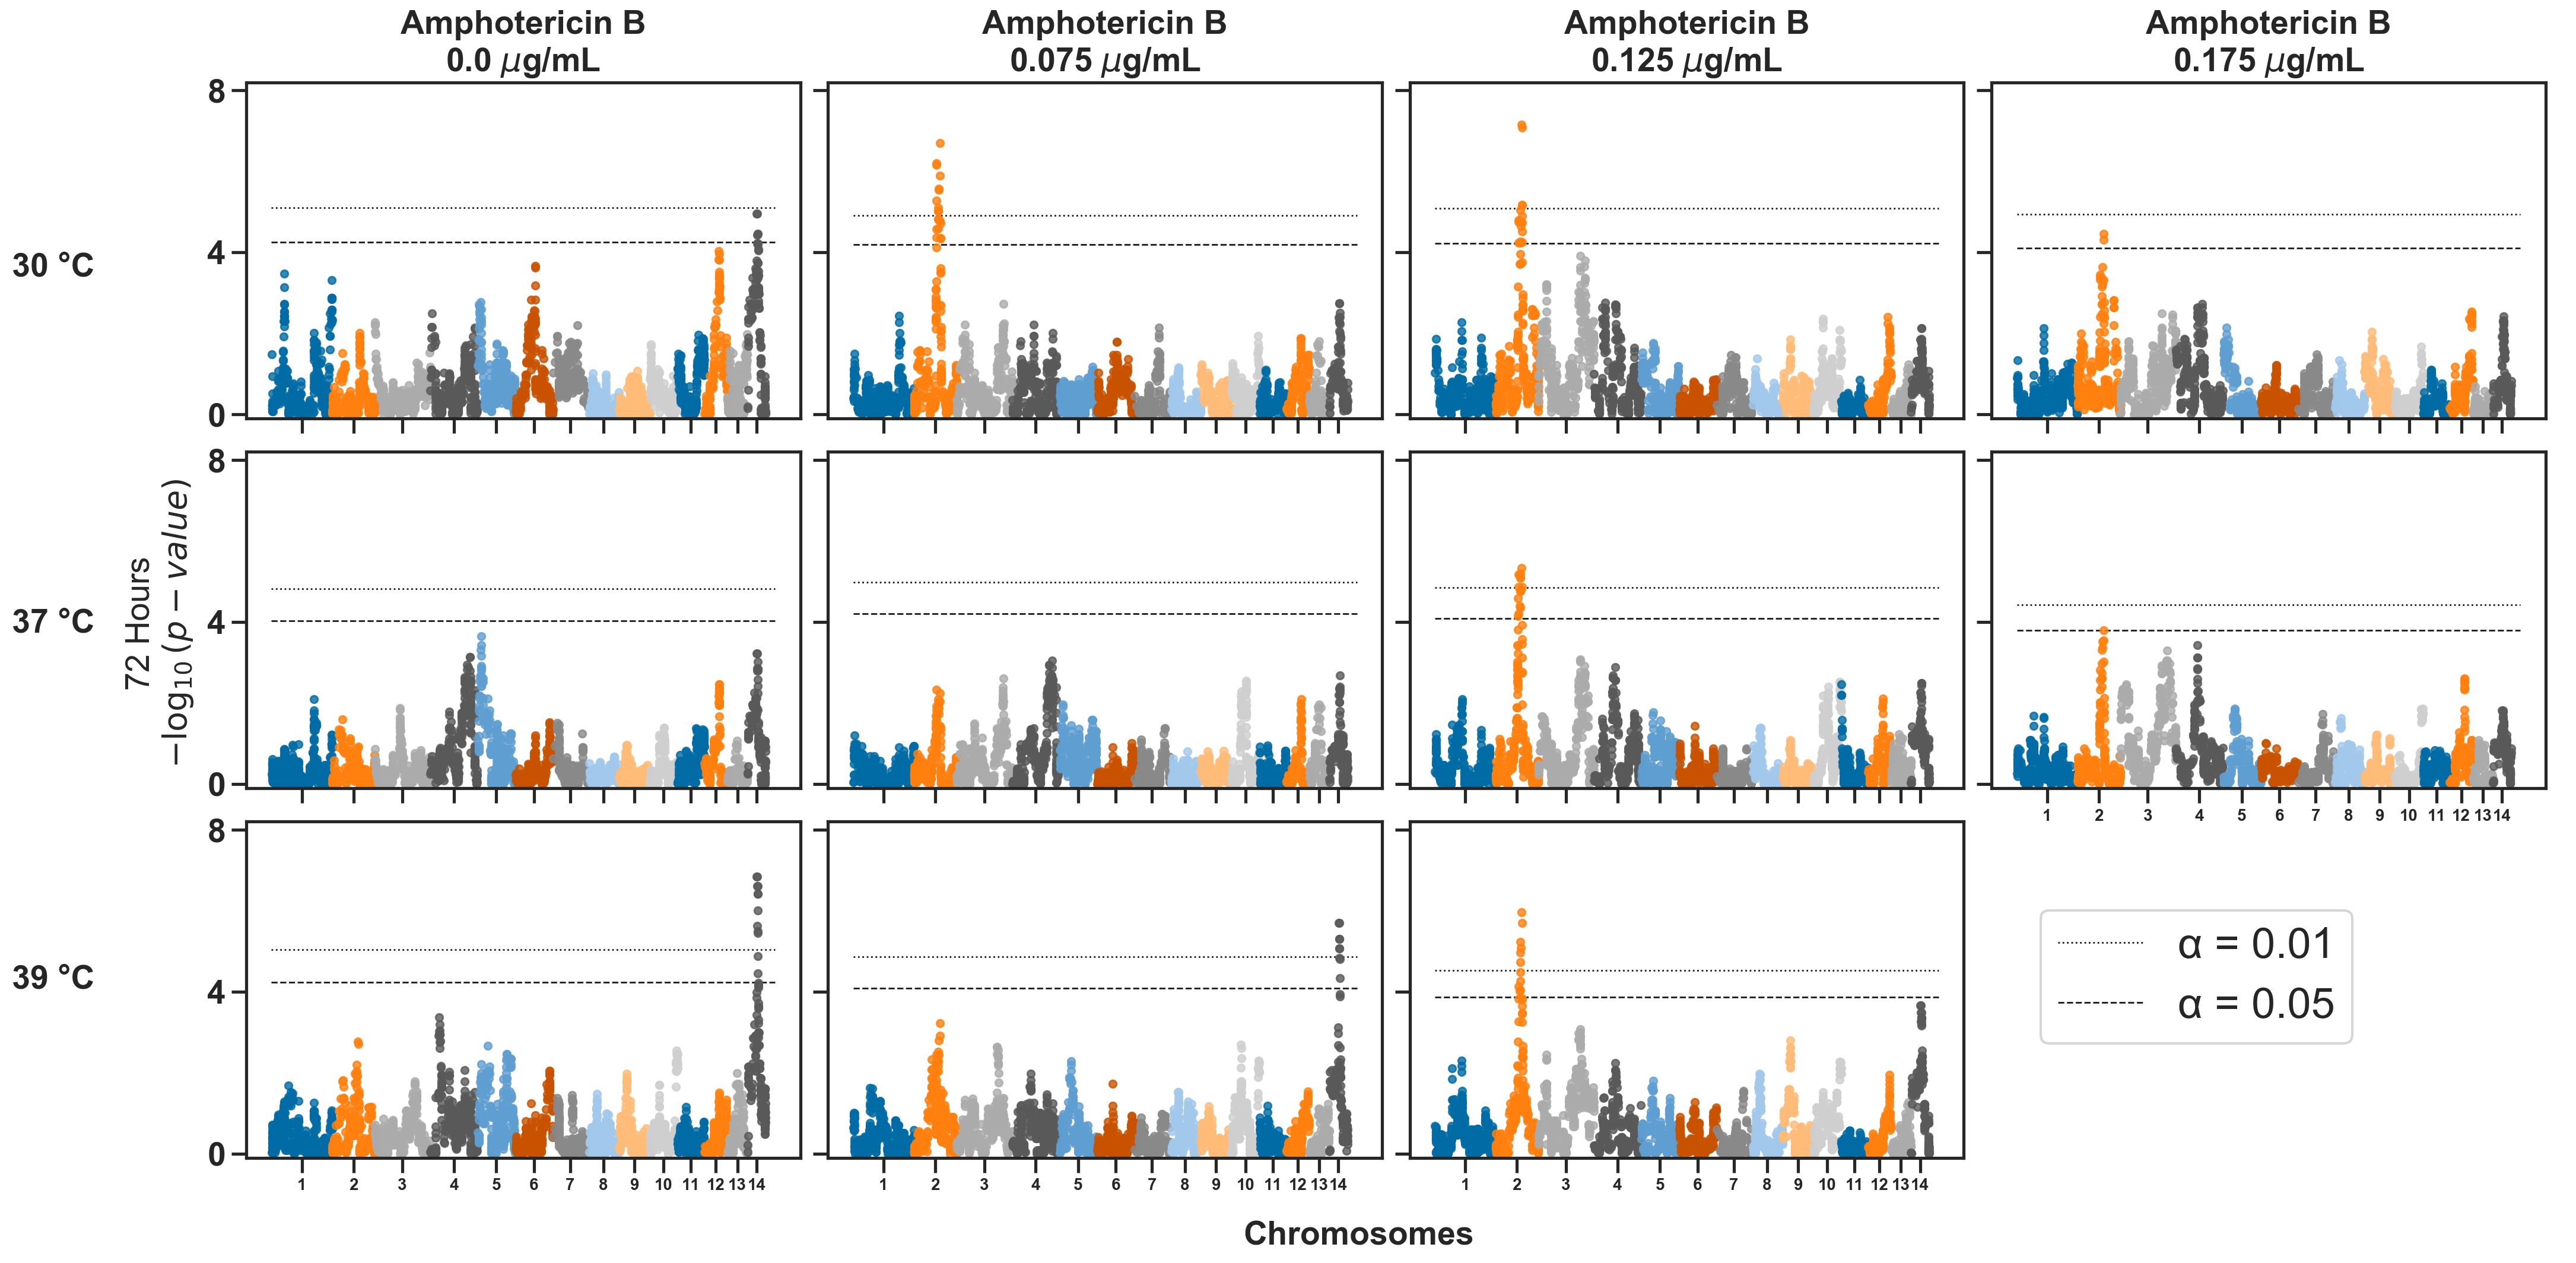

In [45]:
mydpi=200
fig, ax = plt.subplots(3,4,sharey=True,sharex=False,
                       figsize=(25,12),dpi=mydpi)
for i, td in enumerate(txd):
    plt.sca(ax.ravel()[i])
    for c,chrom in enumerate(chrlist):
        
        temp_mm = qtlxt[(qtlxt.Temp==td[0]) & 
                         (qtlxt.AmphB==td[1]) & 
                        (qtlxt.Chrom==chrom)][[times_ixs[-1],'Pos']]
    
        
        plt.plot(temp_mm.Pos.values+cumpos[c],
                 temp_mm[times_ixs[-1]].values,'.',alpha=.8)
                 #label='Max' if (i == 8) and c ==13 else None)
      
    ax.ravel()[i].set_xticks(chrom_midpts);
    ax.ravel()[i].set_yticks(np.arange(0,12,4));
    ax.ravel()[i].set_yticklabels(np.arange(0,12,4),
                                  fontsize=20,fontweight='bold');
    thres = thresholds[(thresholds.Temp==td[0]) & 
                       (thresholds.Amphb==td[1]) & 
                       (thresholds.Stat=='Last')][['0.01','0.05']].T.values
    [plt.hlines(a,0,19*(10**6),color='k',
                linestyle= sigs_ls[z],
                label = sig_labs[z] if i == 10 else None,
                linewidth=1) for z,a in enumerate(thres)]

    plt.ylim(-0.1,8.2)
    if i in np.arange(7,11):
        ax.ravel()[i].set_xticklabels(np.arange(1,15),
                fontsize=10,fontweight='bold');
    else:
        ax.ravel()[i].set_xticklabels([' ' for n in range(14)],
                    fontsize=14,fontweight='bold');

ax[-1,-1].axis('off') ## Turn off last unused axis
plt.subplots_adjust(wspace=0.05,hspace=0.1);
fig.text(0.5,0.07,'Chromosomes',fontweight='bold',
         size=20,va='center',ha='center');

fig.text(0.102,0.5,u'72 Hours\n$-\log_{10}\,(p-value)$\n',
         size=20,va='center',ha='center',rotation=90);

[fig.text(.06,0.75-(0.25*i),u'%s °C'%(t),
             ha='center',va='center',
            fontsize=20,fontweight='bold') for i,t in enumerate(temps)];

#plt.sca(ax[0,0]);plt.title('No Drug',fontsize=20,fontweight='bold');
for i,d in enumerate(drugs):
    plt.sca(ax[0,i])
    plt.title('Amphotericin B\n'+str(d)+r' ${\mu}$'+ 'g/mL',
                            fontweight='bold',fontsize=20)
plt.sca(ax[-1,-2])
plt.legend(bbox_to_anchor=[1.1,0.8],fontsize=16,prop={'size':26})
fig.savefig('%scdx_time_QTL_AUCdxt_Last_matrix.png'%(figpath),
          dpi=mydpi,bbox_inches='tight');

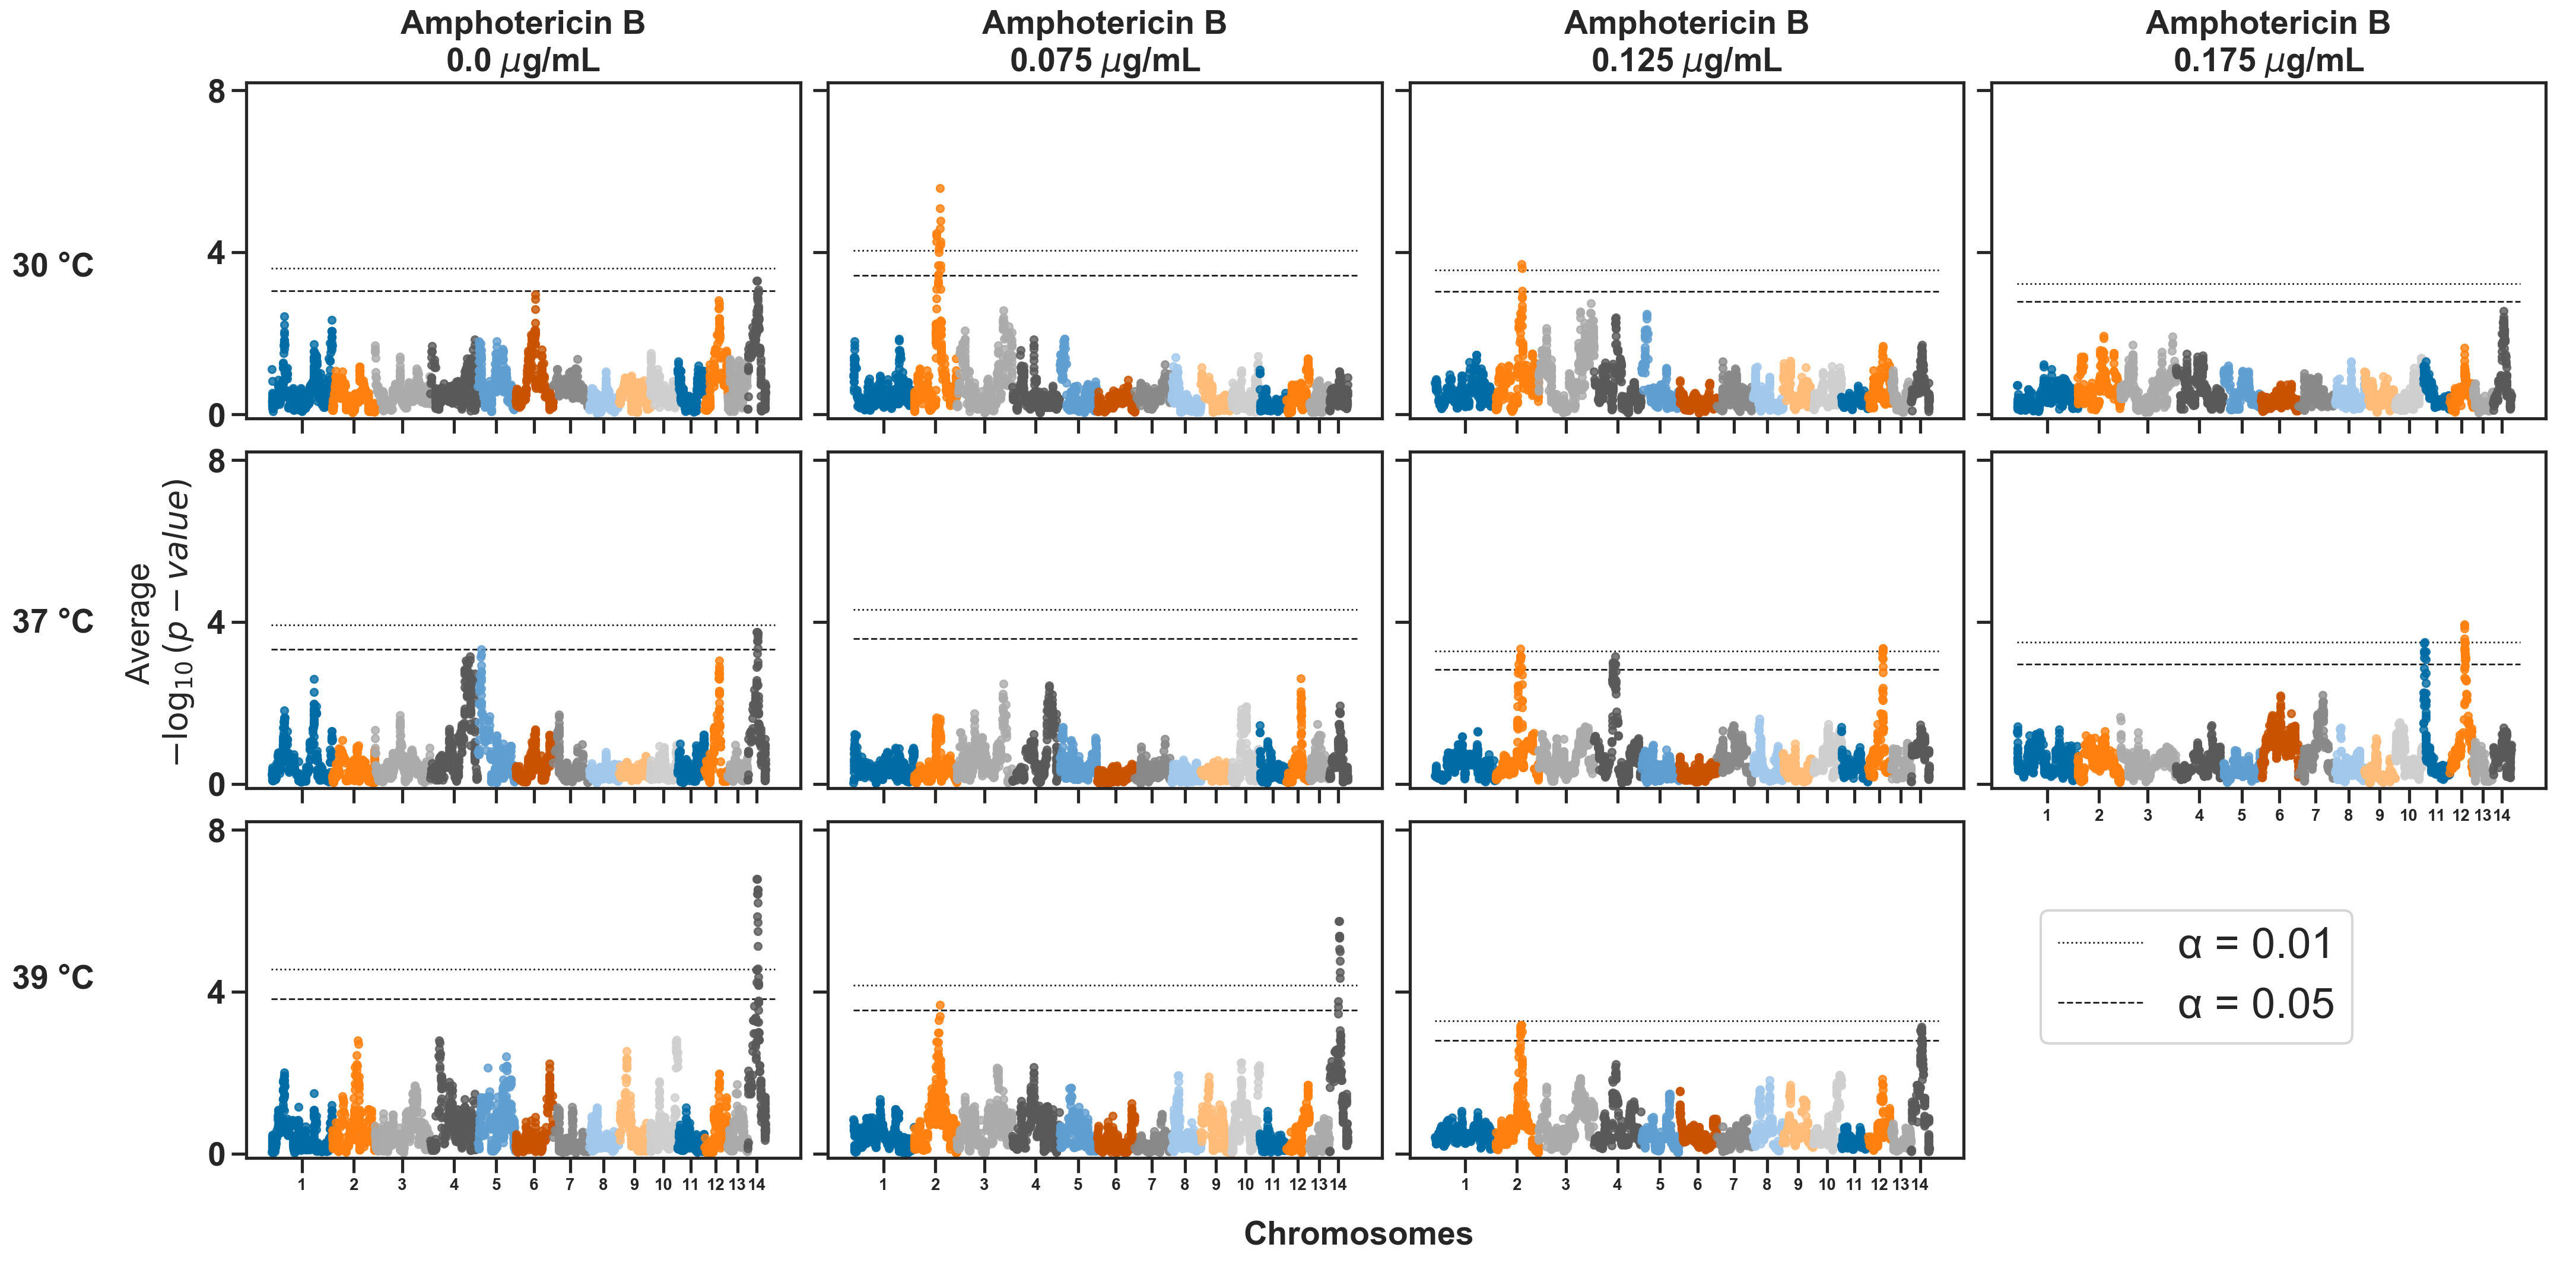

In [46]:
mydpi=200
fig, ax = plt.subplots(3,4,sharey=True,sharex=False,
                       figsize=(25,12),dpi=mydpi)
for i, td in enumerate(txd):
    plt.sca(ax.ravel()[i])
    for c,chrom in enumerate(chrlist):
        
        temp_mm = qtlxt[(qtlxt.Temp==td[0]) & 
                         (qtlxt.AmphB==td[1]) & 
                        (qtlxt.Chrom==chrom)][['Mean','Pos']]
    
        
        plt.plot(temp_mm.Pos.values+cumpos[c],temp_mm.Mean.values,'.',alpha=.8)
                 #label='Max' if (i == 8) and c ==13 else None)
      
    ax.ravel()[i].set_xticks(chrom_midpts);
    ax.ravel()[i].set_yticks(np.arange(0,12,4));
    ax.ravel()[i].set_yticklabels(np.arange(0,12,4),
                                  fontsize=20,fontweight='bold');
    thres = thresholds[(thresholds.Temp==td[0]) & 
                       (thresholds.Amphb==td[1]) & 
                       (thresholds.Stat=='Mean')][['0.01','0.05']].T.values
    [plt.hlines(a,0,19*(10**6),color='k',
                linestyle= sigs_ls[z],
                label = sig_labs[z] if i == 10 else None,
                linewidth=1) for z,a in enumerate(thres)]

    plt.ylim(-0.1,8.2)
    if i in np.arange(7,11):
        ax.ravel()[i].set_xticklabels(np.arange(1,15),
                fontsize=10,fontweight='bold');
    else:
        ax.ravel()[i].set_xticklabels([' ' for n in range(14)],
                    fontsize=14,fontweight='bold');

ax[-1,-1].axis('off') ## Turn off last unused axis
plt.subplots_adjust(wspace=0.05,hspace=0.1);
fig.text(0.5,0.07,'Chromosomes',fontweight='bold',
         size=20,va='center',ha='center');

fig.text(0.102,0.5,u'Average\n$-\log_{10}\,(p-value)$\n',
         size=20,va='center',ha='center',rotation=90);

[fig.text(.06,0.75-(0.25*i),u'%s °C'%(t),
             ha='center',va='center',
            fontsize=20,fontweight='bold') for i,t in enumerate(temps)];

#plt.sca(ax[0,0]);plt.title('No Drug',fontsize=20,fontweight='bold');
for i,d in enumerate(drugs):
    plt.sca(ax[0,i])
    plt.title('Amphotericin B\n'+str(d)+r' ${\mu}$'+ 'g/mL',
                            fontweight='bold',fontsize=20)
plt.sca(ax[-1,-2])
plt.legend(bbox_to_anchor=[1.1,0.8],fontsize=16,prop={'size':26})
fig.savefig('%scdx_time_QTL_AUCdxt_Mean_matrix.png'%(figpath),
          dpi=mydpi,bbox_inches='tight');

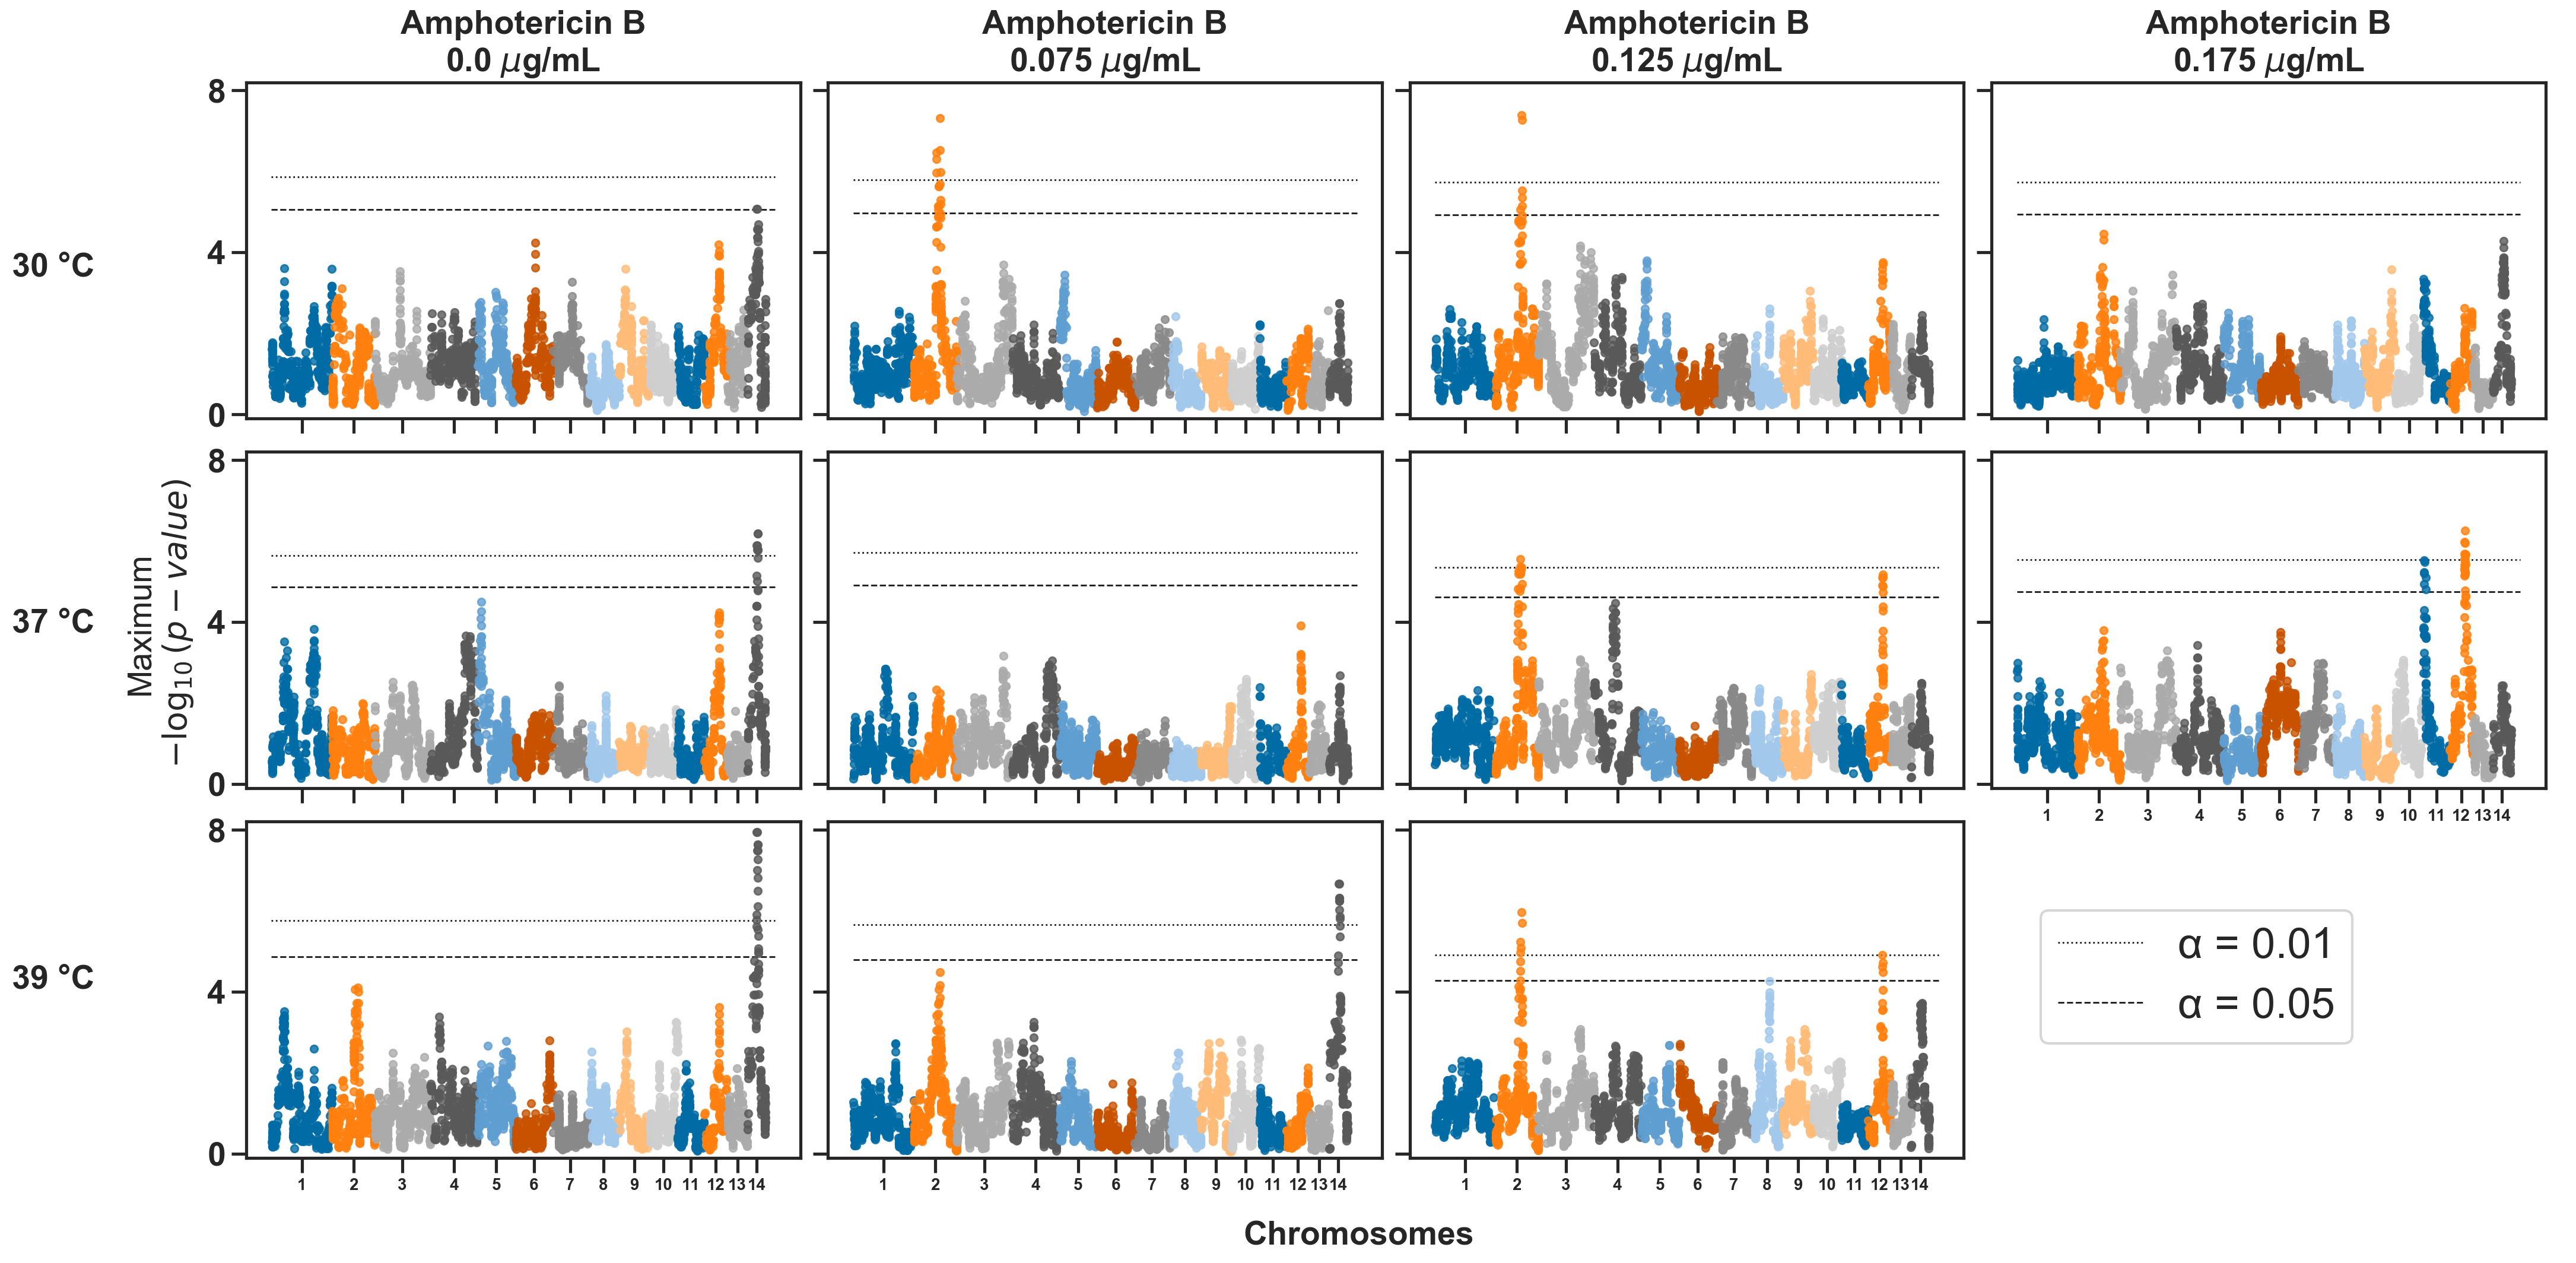

In [47]:
mydpi=200
fig, ax = plt.subplots(3,4,sharey=True,sharex=False,
                       figsize=(25,12),dpi=mydpi)
for i, td in enumerate(txd):
    plt.sca(ax.ravel()[i])
    for c,chrom in enumerate(chrlist):
        
        temp_mm = qtlxt[(qtlxt.Temp==td[0]) & 
                         (qtlxt.AmphB==td[1]) & 
                        (qtlxt.Chrom==chrom)][['Max','Pos']]
    
        
        plt.plot(temp_mm.Pos.values+cumpos[c],temp_mm.Max.values,'.',alpha=.8,
                 label='Max' if (i == 8) and c ==13 else None)
      
    ax.ravel()[i].set_xticks(chrom_midpts);
    ax.ravel()[i].set_yticks(np.arange(0,12,4));
    ax.ravel()[i].set_yticklabels(np.arange(0,12,4),
                                  fontsize=20,fontweight='bold');
    thres = thresholds[(thresholds.Temp==td[0]) & 
                       (thresholds.Amphb==td[1]) & 
                       (thresholds.Stat=='Max')][['0.01','0.05']].T.values
    [plt.hlines(a,0,19*(10**6),color='k',
                linestyle= sigs_ls[z],
                label = sig_labs[z] if i == 10 else None,
                linewidth=1) for z,a in enumerate(thres)]

    plt.ylim(-0.1,8.2)
    if i in np.arange(7,11):
        ax.ravel()[i].set_xticklabels(np.arange(1,15),
                fontsize=10,fontweight='bold');
    else:
        ax.ravel()[i].set_xticklabels([' ' for n in range(14)],
                    fontsize=14,fontweight='bold');

ax[-1,-1].axis('off') ## Turn off last unused axis
plt.subplots_adjust(wspace=0.05,hspace=0.1);
fig.text(0.5,0.07,'Chromosomes',fontweight='bold',
         size=20,va='center',ha='center');

fig.text(0.102,0.5,u'Maximum\n$-\log_{10}\,(p-value)$\n',
        size=20,va='center',ha='center',rotation=90);

[fig.text(.06,0.75-(0.25*i),u'%s °C'%(t),
             ha='center',va='center',
            fontsize=20,fontweight='bold') for i,t in enumerate(temps)];

#plt.sca(ax[0,0]);plt.title('No Drug',fontsize=20,fontweight='bold');
for i,d in enumerate(drugs):
    plt.sca(ax[0,i])
    plt.title('Amphotericin B\n'+str(d)+r' ${\mu}$'+ 'g/mL',
                            fontweight='bold',fontsize=20)
plt.sca(ax[-1,-2])
plt.legend(bbox_to_anchor=[1.1,0.8],fontsize=16,prop={'size':26})
fig.savefig('%scdx_time_QTL_AUCdxt_Max_matrix.png'%(figpath),
          dpi=mydpi,bbox_inches='tight');

In [48]:
temp_max = qtlxt[(qtlxt.Temp.isin([30,37,39])) & 
                 (qtlxt.AmphB==0.0)].groupby(['Chrom','Pos'])['Max'].agg(np.max).reset_index()

In [49]:
temp_drug = qtlxt[(qtlxt.Temp==37) & 
                (qtlxt.AmphB==0.125)][['Max','Chrom','Pos']]

In [50]:
ch12ix = temp_drug[(temp_drug.Chrom=='Chr12')].Max.idxmax()
print('Index of chromosome %s'%(ch12ix))
ch12ix_max = qtlxt[(qtlxt.Temp==37.0) & (qtlxt.AmphB==0.125) & 
      (qtlxt.Chrom=='Chr12')].T[[ch12ix]].T[times_ixs].T.astype(float).idxmax().max()
print('Time index of max %s'%(ch12ix_max))

Index of chromosome 82669
Time index of max 106200s


In [51]:
ch02ix = temp_drug[(temp_drug.Chrom=='Chr02')].Max.idxmax()
print('Index of chromosome %s'%(ch02ix))
ch02ix_max = qtlxt[(qtlxt.Temp==37.0) & (qtlxt.AmphB==0.125) & 
      (qtlxt.Chrom=='Chr02')].T[[ch02ix]].T[times_ixs].T.astype(float).idxmax().max()
print('Time index of max %s'%(ch02ix_max))

Index of chromosome 15339
Time index of max 202500s


In [52]:
## Get the genotypes are chrome 02 and 12 qtl
ch12qtl = geno_df.T[ch12ix].T[geno_strains]
ch02qtl = geno_df.T[ch02ix].T[geno_strains]

In [53]:
df_37_0125 = pd.DataFrame((df[(df.temp==37) & 
                             (df.amphB==0.125)][
    times_ixs].sum(axis=1)*dx).groupby('strain').agg('median'),
                          columns=['AUC'])

In [54]:
df_37_0125['QTL2'] = ch02qtl.T[df_37_0125.index]

In [55]:
df_37_0125['QTL12'] = ch12qtl.T[df_37_0125.index]

In [56]:
df_37_0125.dropna(axis=0,inplace=True)

In [57]:
for a in df_37_0125.columns:
    df_37_0125[a] = df_37_0125[a].apply(float)

In [58]:
df_37_0125['SSK1'] = df_37_0125['QTL2']
df_37_0125['SSK2'] = df_37_0125['QTL12']

In [59]:
len(qtlxt.Cumpos)

34188

In [60]:
len(qtlxt.Cumpos.unique())

3108

In [61]:
qtlmaxt = qtlxt.groupby('Cumpos')[['Chrom','Max']].agg(max)
qtlmaxt.reset_index(inplace=True)

In [62]:
import statsmodels.formula.api as smf

In [63]:
from matplotlib.gridspec import GridSpec

In [64]:
sig_chroms = ['Chr02','Chr11','Chr12','Chr14']

In [65]:
chrom_max = pd.DataFrame(qtlmaxt[(qtlmaxt.Chrom.isin(sig_chroms))].groupby('Chrom')['Max'].max())
chrom_max.reset_index(inplace=True)

In [66]:
chrom_max

Chrom       Max
0  Chr02  7.392040
1  Chr11  5.520205
2  Chr12  6.261549
3  Chr14  7.944399

In [67]:
qtlxt['Maxtime'] = [j.T.idxmax() for i,j in qtlxt[times_ixs].iterrows()]

In [68]:
qtlmax_info = pd.concat([qtlxt[(qtlxt.Chrom==chrom_max.values[i][0]) & 
       (qtlxt.Max == chrom_max.values[i][1])][
    ['Temp','AmphB','Chrom','Block','Max','Maxtime']].iloc[[-1],:] 
           for i in range(len(chrom_max))])

In [69]:
qtlmax_info['Maxhour'] = [ np.round(float(a[:-1])/(60**2),2) for a in qtlmax_info.Maxtime]

In [70]:
qtlmax_info

Temp  AmphB  Chrom  Block       Max  Maxtime  Maxhour
15560  30.0  0.125  Chr02    533  7.392040  233100s    64.75
75313  37.0  0.175  Chr11   2508  5.520205  143100s    39.75
82942  37.0  0.175  Chr12   2792  6.261549  134101s    37.25
90473  39.0  0.000  Chr14   3018  7.944399  104401s    29.00

In [71]:
qtlmax_AUC = pd.concat([(df[(df.temp == r.Temp) & 
     (df.amphB == r.AmphB)].groupby(df[(df.temp == r.Temp) & 
                                       (df.amphB == r.AmphB)].index)[times_ixs
                ].cumsum(axis=1).groupby(df[(df.temp == r.Temp) & 
                        (df.amphB == r.AmphB)].index).agg(np.median)*dx)[r.Maxtime] 
 for i,r in qtlmax_info.iterrows()],axis=1)

In [72]:
qtlmax_AUC.head()

233100s   143100s   134101s   104401s
strain                                          
SS-A837   1.453600  0.251375  0.232625  2.059625
SS-B307   9.924525  0.011500  0.009000  2.669750
SS-B308   4.593500  0.178750  0.164750  1.448500
SS-B310   0.645250  0.083400  0.074150  0.001550
SS-B311  31.290475  0.363325  0.359825  2.226500

In [73]:
qtlmax_gv = pd.concat([genoxdf[(genoxdf.Block==b)][geno_strains].T for b in qtlmax_info.Block],axis=1)

In [74]:
qtlmax_gv.head()

15560  75313  82942  90473
SS-B407        1.0    0.0    1.0    0.0
SS-B316        0.0    1.0    1.0    1.0
SS-B898_cor    0.0    0.0    0.0    1.0
SS-B369        0.0    0.0    1.0    0.0
SS-B997        1.0    1.0    1.0    0.0

In [75]:
from matplotlib.ticker import MaxNLocator

In [76]:
qtlmax_info

Temp  AmphB  Chrom  Block       Max  Maxtime  Maxhour
15560  30.0  0.125  Chr02    533  7.392040  233100s    64.75
75313  37.0  0.175  Chr11   2508  5.520205  143100s    39.75
82942  37.0  0.175  Chr12   2792  6.261549  134101s    37.25
90473  39.0  0.000  Chr14   3018  7.944399  104401s    29.00

In [77]:
can_genes = ['SSK1',' ','SSK2','RIC8']

In [78]:
qtlmax_info

Temp  AmphB  Chrom  Block       Max  Maxtime  Maxhour
15560  30.0  0.125  Chr02    533  7.392040  233100s    64.75
75313  37.0  0.175  Chr11   2508  5.520205  143100s    39.75
82942  37.0  0.175  Chr12   2792  6.261549  134101s    37.25
90473  39.0  0.000  Chr14   3018  7.944399  104401s    29.00

In [79]:
xmax = geno_df[(geno_df.Chrom=='Chr14')].Pos.max() + np.max(cumpos)

In [80]:
qtlxtix = pd.concat([a[1].max() 
                     for a in qtlxt.groupby(qtlxt.index)],axis=1).T

In [81]:
qtlxtix.index = loci_ix

In [82]:
qtlxtix.shape

(3108, 289)

In [83]:
qtlxtix.head()

6300s    7201s    8100s    9000s     9901s    10800s    11700s  \
0    1.61684  1.44237  1.32312   1.2146   1.07487  0.981114  0.908134   
232  1.70141  1.50473  1.40224  1.31514   1.18486   1.09092   1.00989   
249    1.564  1.39801  1.30798  1.21762   1.08391   1.00593  0.950789   
252   1.7452  1.58859   1.4864  1.40183   1.26017   1.17876    1.1241   
254  1.34981  1.22005  1.12064  1.02416  0.892663  0.820984  0.774094   

       12601s    13500s    14400s  ...  257400s      Max     Mean Temp  AmphB  \
0     0.90343  0.890616  0.872705  ...  1.47363  2.77516   1.2924   39  0.175   
232  0.942229  0.919812  0.875266  ...  1.43745  2.98007  1.42534   39  0.175   
249  0.902686  0.901738    0.8761  ...  1.29436  2.61919  1.24119   39  0.175   
252   1.07409   1.07575   1.04933  ...  1.58974  2.84151  1.33097   39  0.175   
254  0.732197  0.735129  0.725028  ...  1.58138  2.15954   1.0227   39  0.175   

     Chrom    Pos Block Cumpos Maxtime  
0    Chr01   5016     0   5016  90901s  
232  Chr01  35512     1  35512  90000s  
249  Chr01  36364     2  36364  91800s  
252  Chr01  36573     3  36573   6300s  
254  Chr01  36769     4  36769  89100s  

[5 rows x 289 columns]

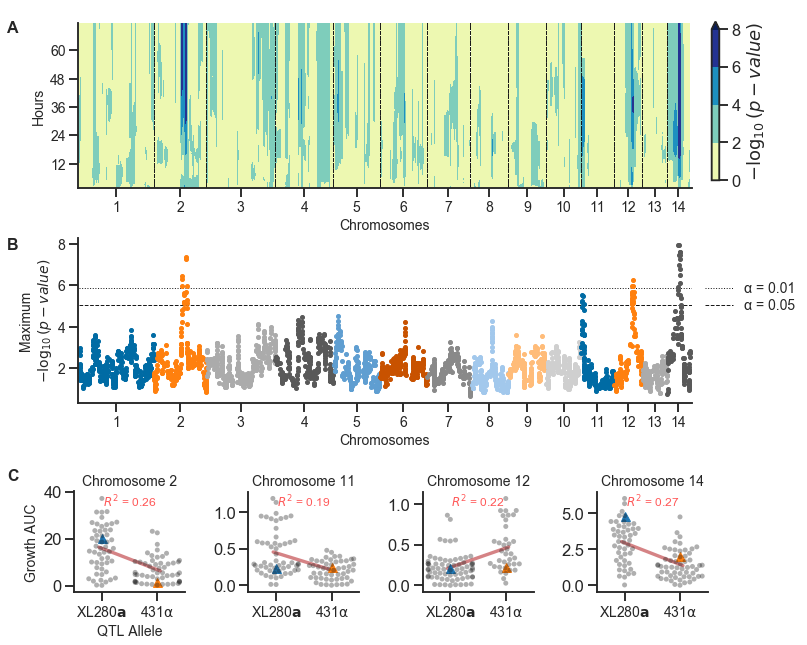

In [84]:
fig, ax = plt.subplots(2,1,figsize=(11,7),sharex=True)
plt.sca(ax[0])

for c,chrom in enumerate(chrlist):
    #temp = qtlxt[(qtlxt.Temp==td[0]) & (qtlxt.AmphB==td[1]) & 
    #    (qtlxt.Chrom==chrom)][times_ixs+['Pos']]
    temp = qtlxtix[(qtlxtix.Chrom==chrom)][times_ixs+['Pos']]
    chpos = temp.Pos.values + cumpos[c]
    cs = ax[0].contourf(chpos,timex,temp[times_ixs].T.values,cmap="YlGnBu",
                        #levels=np.arange(thresholds['0.05'].max().round(2)),extend='max');
                        levels = np.arange(0,9,2),extend='max');
    plt.vlines(np.array(clens[:-1]) + np.array(cumpos[:-1]),
                         1.75,np.max(timex),
           color='k',linewidth=1,linestyle='--');
    plt.xticks(chrom_midpts,labels=np.arange(1,15),
                    fontsize=14);
    ax[0].set_yticks([12,24,36,48,60]);
    ax[0].set_yticklabels([12,24,36,48,60],
                    fontsize=14);
plt.xlabel('Chromosomes',fontsize=14);
plt.ylabel('Hours',fontsize=14)

cbarax = fig.add_axes([.67,0.55,0.3,0.35])
fig.colorbar(cs, shrink=.9,
             label='$-\log_{10}\,(p-value)$',
             orientation='vertical',ax=cbarax)
plt.sca(cbarax)
plt.axis('off')
ax[0].xaxis.set_tick_params(which='both',labelbottom=True);
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
plt.sca(ax[1])
[plt.hlines(a,0,19*(10**6),
           linestyles=list(sigs_ls)[i],color='k',linewidth=1,label=sig_labs[i]) 
 for i,a in enumerate(thresholds[(thresholds.Stat=='Max')][
     ['0.05','0.01']].max().values[::-1])]
[plt.plot(qtlmaxt[(qtlmaxt.Chrom==c)].Cumpos.values,
          qtlmaxt[(qtlmaxt.Chrom==c)].Max.values,'.',ms=8) 
 for c in chrlist];
#plt.ylim(0,8.5);
plt.xticks(chrom_midpts,labels=np.arange(1,len(chrlist)+1),fontsize=14);
plt.xlabel('Chromosomes',fontsize=14);
plt.yticks([2,4,6,8],fontsize=14)
plt.ylabel(u'Maximum\n$-\log_{10}\,(p-value)$',fontsize=14);
plt.legend(bbox_to_anchor=(1,.81),labelspacing=0.2,fontsize=14,frameon=False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
qtl_info_save = []
plt.xlim(-20000,xmax+20000)
plt.subplots_adjust(wspace=0.08,hspace=0.3);
resids = []
for i, j in enumerate(qtlmax_info.iterrows()):
    az = fig.add_axes([.12 + (.22*i),-0.25,0.14,0.2])
    plt.sca(az)
    az.spines['right'].set_visible(False)
    az.spines['top'].set_visible(False)
    temp_auc = qtlmax_AUC[j[1].Maxtime]
    temp_gv = qtlmax_gv[j[0]]
    temp_df = pd.concat([temp_auc,temp_gv],sort=True,axis=1).dropna()
    temp_df.columns = ['auc','gt']
    sns.regplot(x='gt',y='auc',data=temp_df,ci=False,
                scatter_kws={'alpha':0.0},
                line_kws={'color':'r','alpha':0.7})
    sns.swarmplot(x='gt',y='auc',data=temp_df,color='k',alpha=.35)
    plt.plot(*temp_df.T['XL280a'].values[::-1],'^',color='tab:blue')
    plt.plot(*temp_df.T['SS-A837'].values[::-1],'^',color='tab:orange')
    plt.ylabel('Growth AUC' if i == 0 else None,fontsize=14)
    plt.xticks([0,1],labels=[xl280a,_431],fontsize=14)
    plt.xlabel('QTL Allele' if i == 0 else None,fontsize=14)  
    qtlfit = smf.ols('auc~gt',data=temp_df).fit()
    r2 = str(np.round(qtlfit.rsquared,2))
    resids.append(qtlfit.resid)
    #plt.title('%s\n%s\n%s\n%s'%(j[1].Temp,j[1].AmphB,j[1].Maxhour,r2),
    #          fontsize=14,y=1.03)
    plt.title('Chromosome %s'%(int(j[1].Chrom[-2:])),fontsize=14)
    az.text(0.5,.9,'$R^{2}$ = %s'%r2,transform=az.transAxes,
             color='red',alpha=0.65,va='center',ha='center',fontsize=12)
fig.text(0.05,0.87,'A',ha='right',va='center',fontweight='bold',fontsize=16);
fig.text(0.05,0.44,'B',ha='right',va='center',fontweight='bold',fontsize=16);
fig.text(0.05,-0.02,'C',ha='right',va='center',fontweight='bold',fontsize=16);
plt.savefig('%sCdx-temporal-QTL.png'%(figpath),dpi=200,bbox_inches='tight');

In [85]:
qtlmax_info

Temp  AmphB  Chrom  Block       Max  Maxtime  Maxhour
15560  30.0  0.125  Chr02    533  7.392040  233100s    64.75
75313  37.0  0.175  Chr11   2508  5.520205  143100s    39.75
82942  37.0  0.175  Chr12   2792  6.261549  134101s    37.25
90473  39.0  0.000  Chr14   3018  7.944399  104401s    29.00

In [86]:
geno_df[(geno_df.Block.isin(qtlmax_info.Block)) & (geno_df.Chrom=='Chr11')]

Chrom    Pos     Qual  Callrate        Ref Alt  Altlen    Dp   Type  \
75313  Chr11  38191  88356.0       1.0  GTCCCCCCT  GT       1  6077  indel   

       Vcfix  ...  SS-B598  SS-B565  SS-B600  SS-B574  SS-B872_cor  \
75313   2027  ...      0.0      0.0      1.0      0.0          1.0   

       SS-B873_cor  SS-B360  SS-B397  SS-B564  SS-B382  
75313          0.0      0.0      0.0      1.0      0.0  

[1 rows x 125 columns]

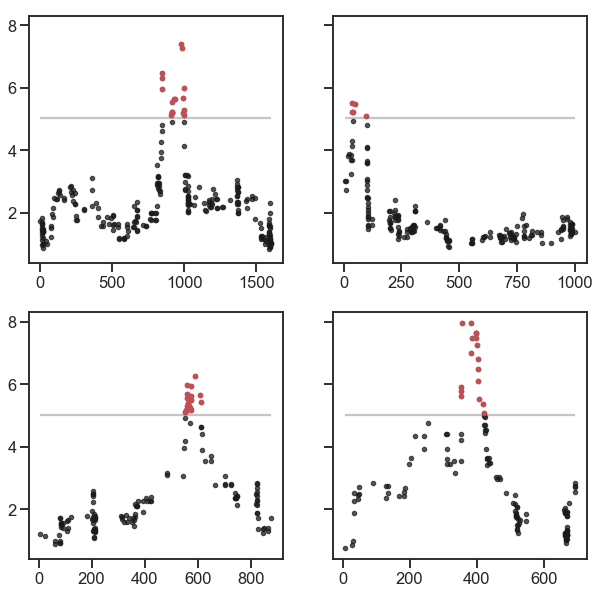

In [87]:
mythres = 5.02
fig,ax = plt.subplots(2,2,figsize=(10,10),sharey=True);
qtl_bounds = []
for i,ch in enumerate(qtlmax_info.Chrom.tolist()):
    plt.sca(ax.ravel()[i])
    chqt = qtlxt[(qtlxt.Chrom==ch)]
    chqts = chqt[['Max','Pos']].sort_values(['Pos','Max'], ascending =False).drop_duplicates('Pos')

    plt.plot(chqts.Pos.values/1000,chqts.Max.values,'k.',alpha=0.75)
    plt.plot(chqts[(chqts.Max>mythres)].Pos.values/1000,
             chqts[(chqts.Max>mythres)].Max.values,'r.')
    plt.hlines(mythres,chqts.Pos.min()/1000,chqts.Pos.max()/1000,alpha=0.25)
    qtl_bounds.append((ch,chqts[(chqts.Max>mythres)].Pos.min(),chqts[(chqts.Max>mythres)].Pos.max()))

In [88]:
qtlmax_info = qtlmax_info.merge(pd.DataFrame(qtl_bounds,columns=['Chrom','Left','Right']))
qtlmax_info['Size'] = qtlmax_info[['Left','Right']].diff(axis=1)['Right']
qtlmax_info

Temp  AmphB  Chrom  Block       Max  Maxtime  Maxhour    Left    Right  \
0  30.0  0.125  Chr02    533  7.392040  233100s    64.75  847396  1001013   
1  37.0  0.175  Chr11   2508  5.520205  143100s    39.75   37942    98127   
2  37.0  0.175  Chr12   2792  6.261549  134101s    37.25  552849   611163   
3  39.0  0.000  Chr14   3018  7.944399  104401s    29.00  353726   422583   

       Size  
0  153617.0  
1   60185.0  
2   58314.0  
3   68857.0

In [89]:
qtl_genes = []
for i, j in qtlmax_info.iterrows():
    locs = j[['Chrom','Left','Right']]
    qtlgene = gff[(gff.type=='gene') & (gff.contig==locs[0]) & 
        (gff.end>=locs['Left']-1) & (gff.start<=locs['Right']+1)][['contig','gene','start','end']]
    qtl_genes.append(qtlgene)

In [90]:
qtlmax_info['Genes'] = [len(q) for q in qtl_genes]

In [91]:
qtlmax_info['Genes'].sum()

140

In [92]:
qtlmax_info

Temp  AmphB  Chrom  Block       Max  Maxtime  Maxhour    Left    Right  \
0  30.0  0.125  Chr02    533  7.392040  233100s    64.75  847396  1001013   
1  37.0  0.175  Chr11   2508  5.520205  143100s    39.75   37942    98127   
2  37.0  0.175  Chr12   2792  6.261549  134101s    37.25  552849   611163   
3  39.0  0.000  Chr14   3018  7.944399  104401s    29.00  353726   422583   

       Size  Genes  
0  153617.0     53  
1   60185.0     21  
2   58314.0     27  
3   68857.0     39

In [93]:
qtl_gene_df = pd.concat(qtl_genes)
qtl_gene_df.columns = ['chrom','gene','start','end']
qtl_gene_df = qtl_gene_df.merge(genes)

In [94]:
qtl_gene_df.groupby('chrom').count()

gene  start  end  mod_three  length_check  nonsense  missense
chrom                                                               
Chr02    38     38   38         38            38        38        38
Chr11    20     20   20         20            20        20        20
Chr12    25     25   25         25            25        25        25
Chr14    30     30   30         30            30        30        30

In [95]:
to_paper = qtl_gene_df[(qtl_gene_df.missense!=0)][[
    'gene','chrom','start','end','nonsense','missense']].copy()

descript = [gff[(gff.gene==g) & 
                (gff.type=='gene')
               ]['description'].values[0].split('%2C')[0] 
 for g in to_paper['gene'].tolist()]

strand = [gff[(gff.gene==g) & 
              (gff.type=='gene')
             ]['strand'].values[0] 
          for g in to_paper['gene'].tolist()]

aac = []
for i,j in to_paper.iterrows():
    if j.nonsense == 0:
        aac.append(j.missense)
    elif j.nonsense == 1:
        aac.append('SG')
    else:
        assert j.nonsense == 2
        aac.append('SL')
    
to_paper['chrom'] = [int(c[-2:]) for c in to_paper.chrom.tolist()]
to_paper['Strand'] = strand
to_paper['Description'] = descript
to_paper['Amino Acid Change'] = aac
to_paper.drop(['nonsense','missense'],axis=1,inplace=True)
to_paper.columns = ['Gene (JEC21)','Chrom',"5'","3'",
                    'Strand','Description','Amino Acid Change']
to_paper.sort_values(['Chrom',"5'"],inplace=True)
to_paper.reset_index(inplace=True,drop=True)

In [96]:
to_paper.head()

Gene (JEC21)  Chrom      5'      3' Strand               Description  \
0     CNB02850      2  844015  847807      -    Ser/Thr protein kinase   
1     CNB02860      2  847924  849735      +  tRNA adenylyltransferase   
2     CNB02995      2  909424  912112      -      hypothetical protein   
3     CNB03000      2  912354  914674      -      hypothetical protein   
4     CNB03005      2  915246  917758      -      hypothetical protein   

  Amino Acid Change  
0                 5  
1                 3  
2                 1  
3                 3  
4                 3

In [97]:
to_paper.groupby('Chrom').count()

Gene (JEC21)  5'  3'  Strand  Description  Amino Acid Change
Chrom                                                              
2                21  21  21      21           21                 21
11               10  10  10      10           10                 10
12               16  16  16      16           16                 16
14               19  19  19      19           19                 19

In [98]:
to_paper.to_csv('%sGene_Tabel.csv'%(filepath),index=False)

In [99]:
non_syn = qtl_gene_df[(qtl_gene_df.missense!=0)].groupby('chrom').count()['gene']

In [100]:
qtlmax_info['Nonsyn'] = non_syn.values
qtlmax_info.to_csv('%sCdx-max-QTL-info.csv'%(filepath),index=True)
qtlmax_info

Temp  AmphB  Chrom  Block       Max  Maxtime  Maxhour    Left    Right  \
0  30.0  0.125  Chr02    533  7.392040  233100s    64.75  847396  1001013   
1  37.0  0.175  Chr11   2508  5.520205  143100s    39.75   37942    98127   
2  37.0  0.175  Chr12   2792  6.261549  134101s    37.25  552849   611163   
3  39.0  0.000  Chr14   3018  7.944399  104401s    29.00  353726   422583   

       Size  Genes  Nonsyn  
0  153617.0     53      21  
1   60185.0     21      10  
2   58314.0     27      16  
3   68857.0     39      19

In [101]:
ch11_12 = pd.concat([qtlmax_AUC[['143100s']],
                     qtlmax_gv[[75313,82942]]],axis=1,sort=True).dropna()
ch11_12.columns = ['AUC','Chr11','Chr12']
ch11_12.head()

AUC  Chr11  Chr12
SS-A837  0.251375    1.0    1.0
SS-B307  0.011500    0.0    0.0
SS-B310  0.083400    1.0    0.0
SS-B311  0.363325    1.0    0.0
SS-B312  0.107575    1.0    0.0

In [102]:
res = smf.ols('AUC~Chr12*Chr11',data=ch11_12).fit()
r11x12 = np.round(res.rsquared,2)
r11x12

0.42

In [103]:
res = smf.ols('AUC~SSK2*SSK1',data=df_37_0125).fit()
r2x12 = np.round(res.rsquared,2)
r2x12

0.27

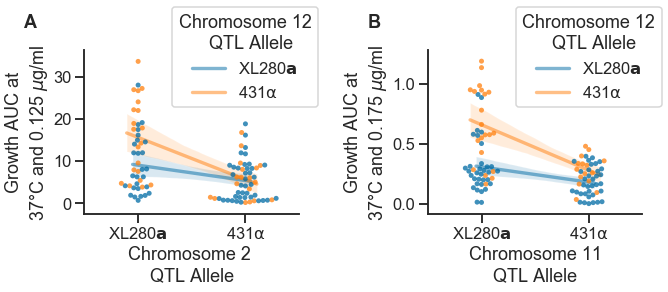

In [104]:
fig, ax= plt.subplots(1,2,figsize=(10,3))
plt.sca(ax[0])
sns.regplot(x='SSK1',y='AUC',data=df_37_0125[(df_37_0125.SSK2==0)],
            scatter_kws={'alpha':0},line_kws={'alpha':0.5})
sns.regplot(x='SSK1',y='AUC',data=df_37_0125[(df_37_0125.SSK2==1)],
            scatter_kws={'alpha':0},line_kws={'alpha':0.5})
sns.swarmplot(x='SSK1',y='AUC',hue='SSK2',data=df_37_0125,alpha=0.75)
plt.ylabel(u'Growth AUC at\n37°C and 0.125'+r' ${\mu}$'+ 'g/ml');
plt.xticks([0,1],labels=[xl280a,_431]);
#plt.xlabel('Chromosome 2 QTL\n' + r'$\it{SSK1}$'+' Allele')
plt.xlabel('Chromosome 2 \nQTL Allele')
plt.title('A',fontweight='bold',x=-0.25,y=1.1)
#plt.legend(title='Chromosome 12 \nQTL\n'+r'        $\it{SSK2}$'+' Allele', 
plt.legend(title='Chromosome 12\n      QTL Allele', 
           bbox_to_anchor=(.37,.6), 
           labels= [xl280a, _431]);

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
plt.sca(ax[1])
sns.regplot(x='Chr11',y='AUC',data=ch11_12[(ch11_12.Chr12==0)],
            scatter_kws={'alpha':0},line_kws={'alpha':0.5})
sns.regplot(x='Chr11',y='AUC',data=ch11_12[(ch11_12.Chr12==1)],
            scatter_kws={'alpha':0},line_kws={'alpha':0.5})
sns.swarmplot(x='Chr11',y='AUC',hue='Chr12',data=ch11_12,alpha=0.75)
plt.ylabel(u'Growth AUC at\n37°C and 0.175'+r' ${\mu}$'+ 'g/ml');
plt.xticks([0,1],labels=[xl280a,_431]);
plt.xlabel('Chromosome 11\nQTL Allele')
plt.legend(title='Chromosome 12\n      QTL Allele', 
           bbox_to_anchor=(.37,.6), 
           labels= [xl280a, _431]);
#ax[1].get_legend().remove()
plt.title('B',fontweight='bold',x=-0.25,y=1.1)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
plt.subplots_adjust(wspace=.6)
plt.savefig('%sCdx_QTL_Interaction.png'%(figpath),
            dpi=150,bbox_inches='tight')